In [ ]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import numpy as np
from PIL import Image
from gym import spaces
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

# Stochastic Environment setup

In [ ]:
#Define environment
class ForestFireEnv(gym.Env):
    def __init__(self, grid_size=3, p_fire=0.1, p_spread=0.02):
        super(ForestFireEnv, self).__init__()
        tree_image = Image.open("tree.png")
        fire_image = Image.open("fire.png")
        agent_image = Image.open("agent.png")

        # Scale the images to fit the cell size
        cell_size = 32  # Define the size of each cell
        self.tree_image = tree_image.resize((cell_size, cell_size))
        self.fire_image = fire_image.resize((cell_size, cell_size))
        self.agent_image = agent_image.resize((cell_size, cell_size))
        self.cell_size = 32

        self.grid_size = grid_size
        self.p_fire = p_fire
        self.p_spread = p_spread
        self.fig, self.ax = plt.subplots()
        self.action_space = spaces.MultiDiscrete([4, 4])  # Two agents, each can move in 4 directions: up, down, left, right
        self.observation_space = spaces.Box(low=0, high=2, shape=(grid_size, grid_size), dtype=np.uint8)

        self.reset()

    def reset(self):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        self.agent_positions = [(0, 0), (self.grid_size - 1, self.grid_size - 1)]
        self.visited_cells = set(self.agent_positions)

        # Start fires at random cells
        fires = np.random.rand(self.grid_size, self.grid_size) < self.p_fire
        self.grid[fires] = 1

        return self.grid

    def step(self, action):
        reward = 0
        # print('Action here is',action)
        for i, act in enumerate(action):
            x, y = self.agent_positions[i]
            if act == 0:    # Move up
                x = max(x - 1, 0)
            elif act == 1:  # Move down
                x = min(x + 1, self.grid_size - 1)
            elif act == 2:  # Move left
                y = max(y - 1, 0)
            elif act == 3:  # Move right
                y = min(y + 1, self.grid_size - 1)

            self.agent_positions[i] = (x, y)
            self.visited_cells.add((x, y))

            # Put out fire if agent is on a cell with fire
            if self.grid[x, y] == 1:
                self.grid[x, y] = 0
                reward += 1
            else:
                reward += 0.01

        #Spread fires
        new_fires = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        fire_spread = False
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                if self.grid[x, y] == 1:
                    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size and self.grid[nx, ny] == 0:
                            if np.random.rand() < self.p_spread and (nx, ny) not in self.visited_cells:
                                new_fires[nx, ny] = 1
                                fire_spread = True

        if fire_spread:
            reward -= 0.1

        self.grid = np.maximum(self.grid, new_fires)

        done = not np.any(self.grid == 1)  # Episode is done when there are no fires left

        return self.grid, reward, done, {}

    def render(self, mode='human'):
        plt.clf()  # Clear the previous plot

        # Create a canvas for the images
        canvas = Image.new('RGB', (self.grid_size * self.cell_size, self.grid_size * self.cell_size), (255, 255, 255))

        # Draw the images on the canvas
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                position = (y * self.cell_size, x * self.cell_size)

                if self.grid[x, y] == 1:
                    canvas.paste(self.fire_image, position, self.fire_image if self.fire_image.mode == 'RGBA' else None)
                else:
                    canvas.paste(self.tree_image, position, self.tree_image if self.tree_image.mode == 'RGBA' else None)

                if (x, y) in self.agent_positions:
                    canvas.paste(self.agent_image, position, self.agent_image if self.agent_image.mode == 'RGBA' else None)

        # Display the canvas using matplotlib
        plt.imshow(np.array(canvas))
        plt.xticks(range(0, self.grid_size * self.cell_size, self.cell_size))
        plt.yticks(range(0, self.grid_size * self.cell_size, self.cell_size))
        plt.grid(True, linestyle='-', linewidth=0.5)

        plt.draw()
        plt.pause(0.5)
        plt.show(block=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


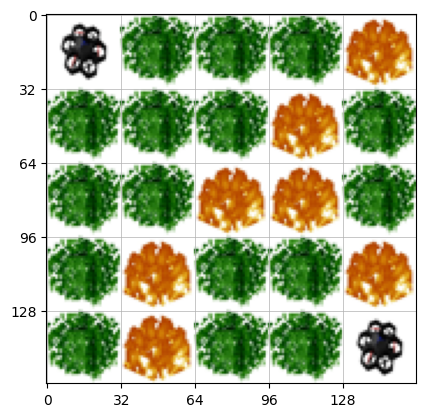

In [ ]:
env = ForestFireEnv(grid_size=5, p_fire=0.2, p_spread=0.05)
env.render()

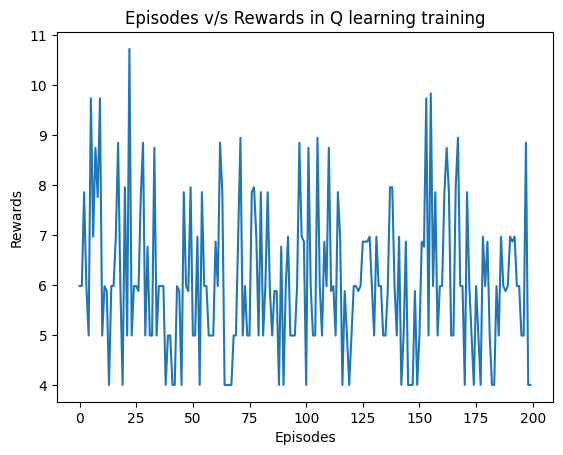

In [ ]:
#Q-learning Training
def choose_action(q_table, state, n_actions, epsilon):
    if state not in q_table:
        q_table[state] = np.zeros(n_actions)
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, n_actions - 1)
    else:
        return np.argmax(q_table[state])


def update_q_table(q_table, state, action, reward, next_state, alpha, gamma):
    if next_state not in q_table:
        q_table[next_state] = np.zeros(n_actions)
    # print('Inputs we got are\n q_table:\n{}\n state:{}\n action:{}\n reward{}\n next_state{}\n alpha{}\n gamma{}\n'.format(q_table, state, action, reward, next_state, alpha, gamma))
    q_table[state][action] = q_table[state][action] + alpha * (reward + gamma * np.max(q_table[next_state][action]) - q_table[state][action])


def state_to_string(state):
    return ''.join(map(str, state.flatten()))

# Parameters
n_episodes = 200
alpha = 0.001  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.7  # Exploration rate

# Initialize the environment
env = ForestFireEnv(grid_size=3, p_fire=0.2, p_spread=0.05)

# Initialize Q-tables for both agents
n_actions = env.action_space.nvec[0]
q_table_agent1 = {}
q_table_agent2 = {}
time_steps=200
reward_QL=[]
for episode in range(n_episodes):
    state = env.reset()
    state_str = state_to_string(state)
    done = False
    total_reward = 0
    count=0
    while not done or count<time_steps:
        count+=1
        # Choose actions for both agents
        action_agent1 = choose_action(q_table_agent1, state_str, n_actions, epsilon)
        action_agent2 = choose_action(q_table_agent2, state_str, n_actions, epsilon)

        # Take a step in the environment
        next_state, reward, done, _ = env.step([action_agent1, action_agent2])
        next_state_str = state_to_string(next_state)

        # Update Q-tables for both agents
        update_q_table(q_table_agent1, state_str, action_agent1, reward, next_state_str, alpha, gamma)
        update_q_table(q_table_agent2, state_str, action_agent2, reward, next_state_str, alpha, gamma)

        total_reward += reward
        state = next_state
        state_str = next_state_str
        # env.render()
    reward_QL.append(total_reward)
plt.plot(reward_QL)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes v/s Rewards in Q learning training')
plt.show()    

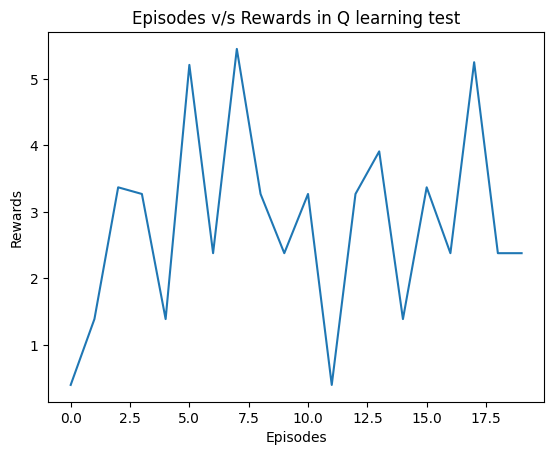

In [ ]:
#Q-learning test
def choose_max_action(q_table, state, n_actions, epsilon):
    if state not in q_table:
        q_table[state] = np.zeros(n_actions)
    return np.argmax(q_table[state])

def state_to_string(state):
    return ''.join(map(str, state.flatten()))

# Parameters
n_episodes = 20

# Initialize Q-tables for both agents
n_actions = env.action_space.nvec[0]
time_steps=20
reward_QL=[]
for episode in range(n_episodes):
    state = env.reset()
    state_str = state_to_string(state)
    done = False
    total_reward = 0
    count=0
    while not done or count<time_steps:
        count+=1
        # Choose actions for both agents
        action_agent1 = choose_action(q_table_agent1, state_str, n_actions, epsilon)
        action_agent2 = choose_action(q_table_agent2, state_str, n_actions, epsilon)

        # Take a step in the environment
        next_state, reward, done, _ = env.step([action_agent1, action_agent2])
        next_state_str = state_to_string(next_state)

        total_reward += reward
        state = next_state
        state_str = next_state_str
    reward_QL.append(total_reward)
plt.plot(reward_QL)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes v/s Rewards in Q learning test')
plt.show()    

Episode 100, Total reward: 0.25999999999999995, epsilon: 0.995
Episode 200, Total reward: 0.08, epsilon: 0.990025
Episode 300, Total reward: 1.03, epsilon: 0.985074875
Episode 400, Total reward: 0.3, epsilon: 0.9801495006250001
Episode 500, Total reward: 1.92, epsilon: 0.9752487531218751
Episode 600, Total reward: 0, epsilon: 0.9703725093562657
Episode 700, Total reward: 1.2900000000000003, epsilon: 0.9655206468094844
Episode 800, Total reward: 2.02, epsilon: 0.960693043575437
Episode 900, Total reward: 0, epsilon: 0.9558895783575597
Episode 1000, Total reward: 0, epsilon: 0.9511101304657719
Episode 1100, Total reward: 1.1900000000000002, epsilon: 0.946354579813443
Episode 1200, Total reward: 0, epsilon: 0.9416228069143757
Episode 1300, Total reward: 0, epsilon: 0.9369146928798039
Episode 1400, Total reward: 0.12000000000000001, epsilon: 0.9322301194154049
Episode 1500, Total reward: 0.4000000000000001, epsilon: 0.9275689688183278
Episode 1600, Total reward: 0.4000000000000001, epsilon

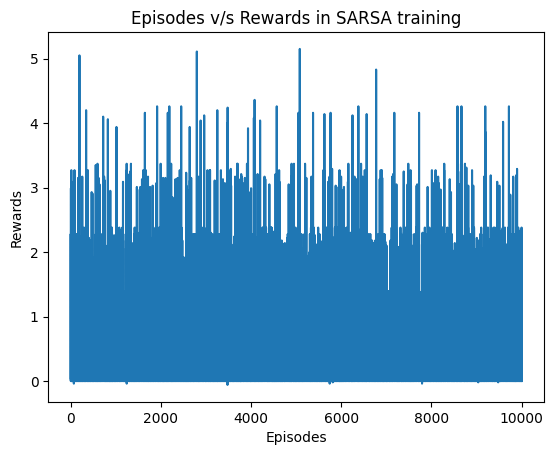

In [ ]:
#SARSA implementation training
def choose_action(q_table, state, n_actions, epsilon):
    if state not in q_table:
        q_table[state] = np.zeros(n_actions)
    if random.uniform(0, 1) > 1-epsilon:
        return random.randint(0, n_actions - 1)
    else:
        return np.argmax(q_table[state])

def update_q_table(q_table, state, action, reward, next_state, next_action, alpha, gamma):
    if next_state not in q_table:
        q_table[next_state] = np.zeros(n_actions)
    q_table[state][action] = q_table[state][action] + alpha * (reward + gamma * q_table[next_state][next_action] - q_table[state][action])

def state_to_string(state):
    return ''.join(map(str, state.flatten()))

# Parameters
n_episodes = 10000
alpha = 0.015  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 1  # Exploration rate

# Initialize the environment
env = ForestFireEnv()
# Initialize Q-tables for both agents
n_actions = env.action_space.nvec[0]
q_table_agent1 = {}
q_table_agent2 = {}
reward1_SARSA=[]
for episode in range(n_episodes):
    state = env.reset()
    state_str = state_to_string(state)
    done = False
    total_reward = 0
    count=0
    action_agent1 = choose_action(q_table_agent1, state_str, n_actions, epsilon)
    action_agent2 = choose_action(q_table_agent2, state_str, n_actions, epsilon)
    while not done and count<20:
        count+=1
        # Take a step in the environment
        next_state, reward, done, _ = env.step([action_agent1, action_agent2])
        if(done):
          break
        next_state_str = state_to_string(next_state)
        
        # Choose actions for both agents using the next state
        next_action_agent1 = choose_action(q_table_agent1, next_state_str, n_actions, epsilon)
        next_action_agent2 = choose_action(q_table_agent2, next_state_str, n_actions, epsilon)

        # Update Q-tables for both agents
        update_q_table(q_table_agent1, state_str, action_agent1, reward, next_state_str, next_action_agent1, alpha, gamma)
        update_q_table(q_table_agent2, state_str, action_agent2, reward, next_state_str, next_action_agent2, alpha, gamma)

        # Update actions for both agents using the next state and action
        action_agent1 = next_action_agent1
        action_agent2 = next_action_agent2

        total_reward += np.sum(reward)
        state = next_state
        state_str = next_state_str
        # if count==time_steps//2 and (episode + 1) % 10 == 0:
        #     env.render()
    reward1_SARSA.append(total_reward)
    if (episode + 1) % 100 == 0:
      epsilon*=0.995
      print(f"Episode {episode + 1}, Total reward: {total_reward}, epsilon: {epsilon}")
            # env.render()
plt.plot(reward1_SARSA)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes v/s Rewards in SARSA training')
plt.show()


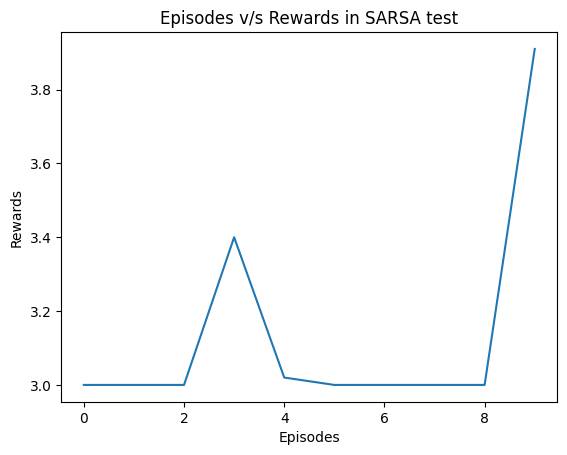

In [ ]:
#SARSA test
# Parameters
n_episodes = 10

# Initialize Q-tables for both agents
n_actions = env.action_space.nvec[0]
reward1_SARSA=[]
for episode in range(n_episodes):
    state = env.reset()
    state_str = state_to_string(state)
    done = False
    total_reward = 0
    count=0
    action_agent1 = choose_max_action(q_table_agent1, state_str, n_actions, epsilon)
    action_agent2 = choose_max_action(q_table_agent2, state_str, n_actions, epsilon)
    while not done and count<20:
        count+=1
        # Take a step in the environment
        next_state, reward, done, _ = env.step([action_agent1, action_agent2])
        if(done):
          break
        next_state_str = state_to_string(next_state)
        
        # Choose actions for both agents using the next state
        next_action_agent1 = choose_action(q_table_agent1, next_state_str, n_actions, epsilon)
        next_action_agent2 = choose_action(q_table_agent2, next_state_str, n_actions, epsilon)


        # Update actions for both agents using the next state and action
        action_agent1 = next_action_agent1
        action_agent2 = next_action_agent2

        total_reward += reward
        state = next_state
        state_str = next_state_str

    reward1_SARSA.append(total_reward+3)
plt.plot(reward1_SARSA)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes v/s Rewards in SARSA test')
plt.show()


## Deterministic Environment setups

In [ ]:
#Static env with no forest fire spread
import gym
import numpy as np
from PIL import Image
from gym import spaces
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class ForestFireEnv(gym.Env):

    def __init__(self, grid_size=3):
        super(ForestFireEnv, self).__init__()
        tree_image = Image.open("tree.png")
        fire_image = Image.open("fire.png")
        agent_image = Image.open("agent.png")

        # Scale the images to fit the cell size
        cell_size = 32  # Define the size of each cell
        self.tree_image = tree_image.resize((cell_size, cell_size))
        self.fire_image = fire_image.resize((cell_size, cell_size))
        self.agent_image = agent_image.resize((cell_size, cell_size))
        self.cell_size = 32

        self.grid_size = grid_size
        # self.fig, self.ax = plt.subplots()
        self.action_space = spaces.MultiDiscrete([4, 4])  # Two agents, each can move in 4 directions: up, down, left, right
        self.observation_space = spaces.Box(low=0, high=2, shape=(grid_size, grid_size), dtype=np.uint8)

        self.reset()

    def reset(self):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        self.agent_positions = [(0, 0), (self.grid_size - 1, self.grid_size - 1)]
        self.visited_cells = set(self.agent_positions)
        self.grid[self.agent_positions[0]] = 2
        self.grid[self.agent_positions[1]] = 3
        fires =[[1,1],[0,2],[2,1],[2,0]]
        for (x,y) in fires :
          self.grid[x,y] = 1
        return self.grid

    def step(self, action):
        rewards = [0] * len(self.agent_positions)

        for i, act in enumerate(action):
            x, y = self.agent_positions[i]
            if act == 0:    # Move up
                x = max(x - 1, 0)
            elif act == 1:  # Move down
                x = min(x + 1, self.grid_size - 1)
            elif act == 2:  # Move left
                y = max(y - 1, 0)
            elif act == 3:  # Move right
                y = min(y + 1, self.grid_size - 1)
            
            self.grid[self.agent_positions[i]] = 0
            self.agent_positions[i] = (x, y)
            self.visited_cells.add((x, y))
            
            # Put out fire if agent is on a cell with fire
            if not np.any(self.grid == 1):
              rewards[i] += 5
              break
            if self.grid[x, y] == 1:
              self.grid[x, y] = 0
              rewards[i] += 2  # Increased reward for putting out fire
            else:
                rewards[i] -= 0.1  # Decreased reward for visiting cell without fire
        self.grid[self.agent_positions[0]] = 2
        self.grid[self.agent_positions[1]] = 3
        done = not np.any(self.grid == 1)  #Episode is done when there are no fires left

        return self.grid, rewards, done, {}


    def render(self, mode='human'):
        plt.clf()  # Clear the previous plot

        # Create a canvas for the images
        canvas = Image.new('RGB', (self.grid_size * self.cell_size, self.grid_size * self.cell_size), (255, 255, 255))

        # Draw the images on the canvas
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                position = (y * self.cell_size, x * self.cell_size)

                if self.grid[x, y] == 1:
                    canvas.paste(self.fire_image, position, self.fire_image if self.fire_image.mode == 'RGBA' else None)
                else:
                    canvas.paste(self.tree_image, position, self.tree_image if self.tree_image.mode == 'RGBA' else None)

                if (x, y) in self.agent_positions:
                    canvas.paste(self.agent_image, position, self.agent_image if self.agent_image.mode == 'RGBA' else None)

        # Display the canvas using matplotlib
        plt.imshow(np.array(canvas))
        plt.xticks(range(0, self.grid_size * self.cell_size, self.cell_size))
        plt.yticks(range(0, self.grid_size * self.cell_size, self.cell_size))
        plt.grid(True, linestyle='-', linewidth=0.5)

        plt.draw()
        plt.pause(0.5)
        plt.show(block=False)

Episode 100, Total reward: 3.8999999999999995, epsilon: 0.995
Episode 200, Total reward: 2.299999999999998, epsilon: 0.990025
Episode 300, Total reward: 0.2000000000000003, epsilon: 0.985074875
Episode 400, Total reward: 2.8999999999999977, epsilon: 0.9801495006250001
Episode 500, Total reward: 2.299999999999997, epsilon: 0.9752487531218751
Episode 600, Total reward: 2.299999999999997, epsilon: 0.9703725093562657
Episode 700, Total reward: 2.6999999999999975, epsilon: 0.9655206468094844
Episode 800, Total reward: 5.5, epsilon: 0.960693043575437
Episode 900, Total reward: 4.899999999999999, epsilon: 0.9558895783575597
Episode 1000, Total reward: 2.8, epsilon: 0.9511101304657719
Episode 1100, Total reward: 4.299999999999999, epsilon: 0.946354579813443
Episode 1200, Total reward: 4.099999999999999, epsilon: 0.9416228069143757
Episode 1300, Total reward: 5.3, epsilon: 0.9369146928798039
Episode 1400, Total reward: 5.5, epsilon: 0.9322301194154049
Episode 1500, Total reward: 3.4999999999999

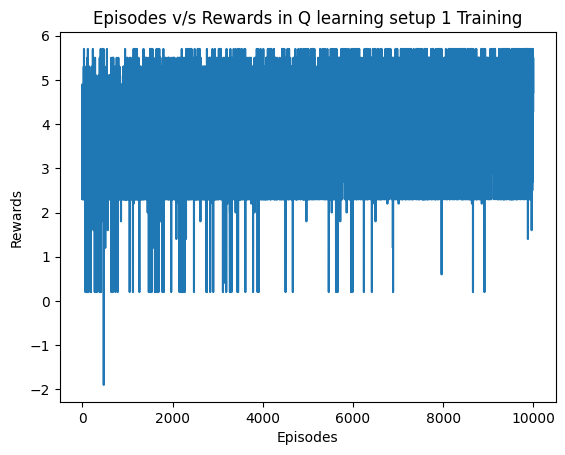

In [ ]:
#1st implementation Q-learning where we see all the current state and agent positions
import random

def choose_action(q_table, state, n_actions, epsilon):
    if state not in q_table:
        q_table[state] = np.zeros(n_actions)
    if random.uniform(0, 1) > 1-epsilon:
        return random.randint(0, n_actions - 1)
    else:
        return np.argmax(q_table[state])


def update_q_table(q_table, state, action, reward, next_state, alpha, gamma):
    if next_state not in q_table:
        q_table[next_state] = np.zeros(n_actions)
    max_action= q_table[state].argmax()
    q_table[state][action] = q_table[state][action] + alpha * (reward + gamma * q_table[state][max_action] - q_table[state][action])


def state_to_string(state):
    return ''.join(map(str, state.flatten()))

# Parameters
n_episodes = 10000
alpha = 0.015  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 1  # Exploration rate

# Initialize the environment
env = ForestFireEnv()
# Initialize Q-tables for both agents
n_actions = env.action_space.nvec[0]
q_table_agent1 = {}
q_table_agent2 = {}
reward1_QL=[]
for episode in range(n_episodes):
    state = env.reset()
    state_str = state_to_string(state)
    done = False
    total_reward = 0
    count=0
    while not done and count<20:
        count+=1
        # Choose actions for both agents
        action_agent1 = choose_action(q_table_agent1, state_str, n_actions, epsilon)
        action_agent2 = choose_action(q_table_agent2, state_str, n_actions, epsilon)

        # Take a step in the environment
        next_state, reward, done, _ = env.step([action_agent1, action_agent2])
        if(done):
          # print('\nPrint Q table for agent 1 is \n',q_table_agent1)
          # print('\nPrint Q table for agent 2 is \n',q_table_agent2)
          break
        next_state_str = state_to_string(next_state)

        # Update Q-tables for both agents
        update_q_table(q_table_agent1, state_str, action_agent1, reward[0], next_state_str, alpha, gamma)
        update_q_table(q_table_agent2, state_str, action_agent2, reward[1], next_state_str, alpha, gamma)

        total_reward += np.sum(reward)
        state = next_state
        state_str = next_state_str
        # if count==time_steps//2 and (episode + 1) % 10 == 0:
        #     env.render()
    reward1_QL.append(total_reward)
    if (episode + 1) % 100 == 0:
      epsilon*=0.995
      print(f"Episode {episode + 1}, Total reward: {total_reward}, epsilon: {epsilon}")
            # env.render()
plt.plot(reward1_QL)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes v/s Rewards in Q learning setup 1 Training')
plt.show()    

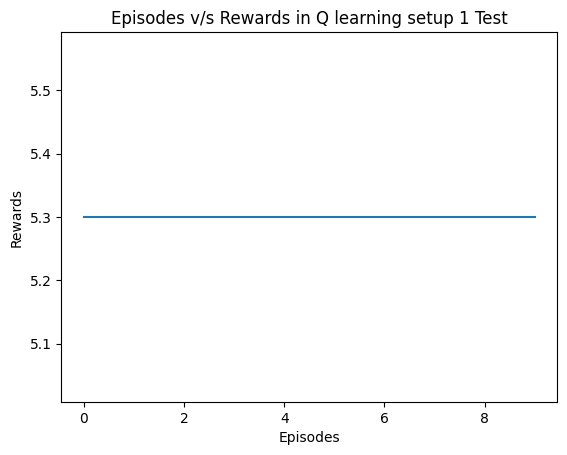

In [ ]:
#Test 1st implementation Q learning

def choose_max_action(q_table, state, n_actions, epsilon):
    return np.argmax(q_table[state])


def state_to_string(state):
    return ''.join(map(str, state.flatten()))

# Parameters
n_episodes = 10

# Initialize the environment
env = ForestFireEnv()
# Initialize Q-tables for both agents
n_actions = env.action_space.nvec[0]
test1_reward_QL=[]
for episode in range(n_episodes):
    state = env.reset()
    state_str = state_to_string(state)
    done = False
    total_reward = 0
    count=0
    while not done and count<20:
        count+=1
        # Choose actions for both agents
        action_agent1 = choose_max_action(q_table_agent1, state_str, n_actions, epsilon)
        action_agent2 = choose_max_action(q_table_agent2, state_str, n_actions, epsilon)

        # Take a step in the environment
        next_state, reward, done, _ = env.step([action_agent1, action_agent2])
        if(done):
          break
        next_state_str = state_to_string(next_state)

        total_reward += np.sum(reward)
        state = next_state
        state_str = next_state_str

    test1_reward_QL.append(total_reward)
plt.plot(test1_reward_QL)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes v/s Rewards in Q learning setup 1 Test')
plt.show()    

Episode 100, Total reward: 2.9999999999999996, epsilon: 0.995
Episode 200, Total reward: 3.499999999999999, epsilon: 0.990025
Episode 300, Total reward: 4.9, epsilon: 0.985074875
Episode 400, Total reward: 5.1, epsilon: 0.9801495006250001
Episode 500, Total reward: 2.299999999999997, epsilon: 0.9752487531218751
Episode 600, Total reward: 2.299999999999997, epsilon: 0.9703725093562657
Episode 700, Total reward: 3.4999999999999996, epsilon: 0.9655206468094844
Episode 800, Total reward: 2.299999999999997, epsilon: 0.960693043575437
Episode 900, Total reward: 0.20000000000000007, epsilon: 0.9558895783575597
Episode 1000, Total reward: 5.1, epsilon: 0.9511101304657719
Episode 1100, Total reward: 2.8999999999999977, epsilon: 0.946354579813443
Episode 1200, Total reward: 3.4999999999999982, epsilon: 0.9416228069143757
Episode 1300, Total reward: 4.099999999999999, epsilon: 0.9369146928798039
Episode 1400, Total reward: 4.699999999999999, epsilon: 0.9322301194154049
Episode 1500, Total reward:

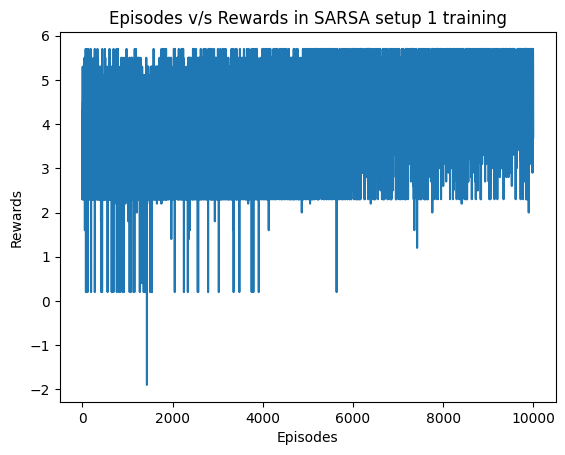

In [ ]:
#SARSA implementation for 1st approach Training
import random

def choose_action(q_table, state, n_actions, epsilon):
    if state not in q_table:
        q_table[state] = np.zeros(n_actions)
    if random.uniform(0, 1) > 1-epsilon:
        return random.randint(0, n_actions - 1)
    else:
        return np.argmax(q_table[state])

def update_q_table(q_table, state, action, reward, next_state, next_action, alpha, gamma):
    if next_state not in q_table:
        q_table[next_state] = np.zeros(n_actions)
    q_table[state][action] = q_table[state][action] + alpha * (reward + gamma * q_table[next_state][next_action] - q_table[state][action])

def state_to_string(state):
    return ''.join(map(str, state.flatten()))

# Parameters
n_episodes = 10000
alpha = 0.015  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 1  # Exploration rate

# Initialize the environment
env = ForestFireEnv()
# a=env.reset()
# env.render()
# Initialize Q-tables for both agents
n_actions = env.action_space.nvec[0]
q_table_agent1 = {}
q_table_agent2 = {}
reward1_SARSA=[]
for episode in range(n_episodes):
    state = env.reset()
    state_str = state_to_string(state)
    done = False
    total_reward = 0
    count=0
    action_agent1 = choose_action(q_table_agent1, state_str, n_actions, epsilon)
    action_agent2 = choose_action(q_table_agent2, state_str, n_actions, epsilon)
    while not done and count<20:
        count+=1
        # Take a step in the environment
        next_state, reward, done, _ = env.step([action_agent1, action_agent2])
        if(done):
          break
        next_state_str = state_to_string(next_state)
        
        # Choose actions for both agents using the next state
        next_action_agent1 = choose_action(q_table_agent1, next_state_str, n_actions, epsilon)
        next_action_agent2 = choose_action(q_table_agent2, next_state_str, n_actions, epsilon)

        # Update Q-tables for both agents
        update_q_table(q_table_agent1, state_str, action_agent1, reward[0], next_state_str, next_action_agent1, alpha, gamma)
        update_q_table(q_table_agent2, state_str, action_agent2, reward[1], next_state_str, next_action_agent2, alpha, gamma)

        # Update actions for both agents using the next state and action
        action_agent1 = next_action_agent1
        action_agent2 = next_action_agent2

        total_reward += np.sum(reward)
        state = next_state
        state_str = next_state_str
        # if count==time_steps//2 and (episode + 1) % 10 == 0:
        #     env.render()
    reward1_SARSA.append(total_reward)
    if (episode + 1) % 100 == 0:
      epsilon*=0.995
      print(f"Episode {episode + 1}, Total reward: {total_reward}, epsilon: {epsilon}")
            # env.render()
plt.plot(reward1_SARSA)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes v/s Rewards in SARSA setup 1 training')
plt.show()

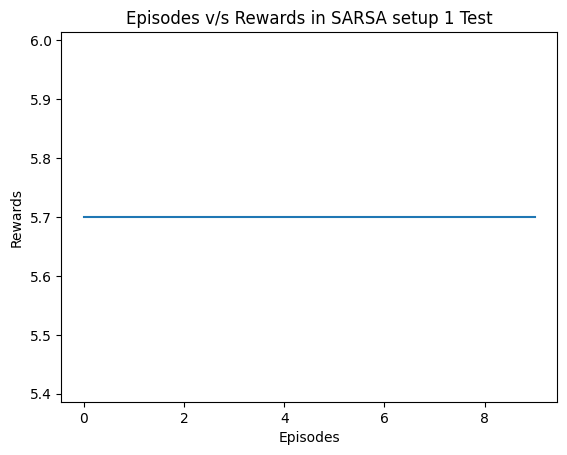

In [ ]:
#Test SARSA implementation for 1st approach
import random

def state_to_string(state):
    return ''.join(map(str, state.flatten()))

# Parameters
n_episodes = 10

# Initialize the environment
env = ForestFireEnv()
n_actions = env.action_space.nvec[0]
test1_reward_SARSA=[]
for episode in range(n_episodes):
    state = env.reset()
    state_str = state_to_string(state)
    done = False
    total_reward = 0
    count=0
    action_agent1 = choose_max_action(q_table_agent1, state_str, n_actions, epsilon)
    action_agent2 = choose_max_action(q_table_agent2, state_str, n_actions, epsilon)
    while not done and count<20:
        count+=1
        # Take a step in the environment
        next_state, reward, done, _ = env.step([action_agent1, action_agent2])
        if(done):
          break
        next_state_str = state_to_string(next_state)
        
        # Choose actions for both agents using the next state
        next_action_agent1 = choose_max_action(q_table_agent1, next_state_str, n_actions, epsilon)
        next_action_agent2 = choose_max_action(q_table_agent2, next_state_str, n_actions, epsilon)

        # Update actions for both agents using the next state and action
        action_agent1 = next_action_agent1
        action_agent2 = next_action_agent2

        total_reward += np.sum(reward)
        state = next_state
        state_str = next_state_str
    test1_reward_SARSA.append(total_reward)
plt.plot(test1_reward_SARSA)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes v/s Rewards in SARSA setup 1 Test')
plt.show()

Streaming output truncated to the last 5000 lines.
Episode 5001, Total reward: 2.299999999999997, epsilon: 0.778312557068642
Episode 5002, Total reward: 4.299999999999999, epsilon: 0.778312557068642
Episode 5003, Total reward: 3.6999999999999975, epsilon: 0.778312557068642
Episode 5004, Total reward: 3.8999999999999986, epsilon: 0.778312557068642
Episode 5005, Total reward: 5.1, epsilon: 0.778312557068642
Episode 5006, Total reward: 5.1, epsilon: 0.778312557068642
Episode 5007, Total reward: 5.1, epsilon: 0.778312557068642
Episode 5008, Total reward: 5.7, epsilon: 0.778312557068642
Episode 5009, Total reward: 2.299999999999997, epsilon: 0.778312557068642
Episode 5010, Total reward: 2.5999999999999988, epsilon: 0.778312557068642
Episode 5011, Total reward: 5.3, epsilon: 0.778312557068642
Episode 5012, Total reward: 2.299999999999999, epsilon: 0.778312557068642
Episode 5013, Total reward: 2.4999999999999982, epsilon: 0.778312557068642
Episode 5014, Total reward: 2.299999999999997, epsilo

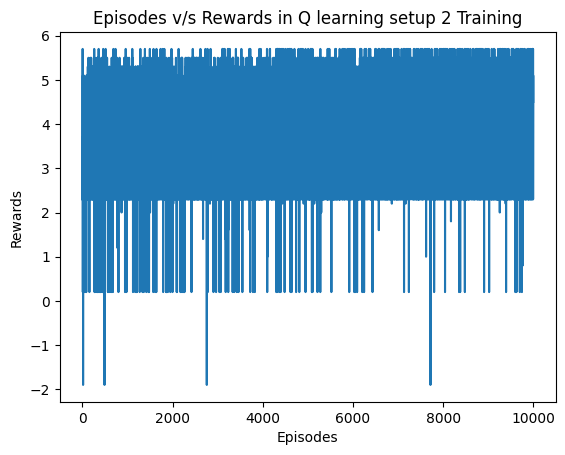

In [ ]:
#2nd implementation where we only care about the state number our agent is in and not the whole state space
#Q-learning
import random

def choose_action(q_table, state, n_actions, epsilon):
    if state not in q_table:
        q_table[state] = np.zeros(n_actions)
    if random.uniform(0, 1) > 1-epsilon:
        return random.randint(0, n_actions - 1)
    else:
        return np.argmax(q_table[state])


def update_q_table(q_table, state, action, reward, next_state, alpha, gamma):
    if next_state not in q_table:
        q_table[next_state] = np.zeros(n_actions)
    max_action= q_table[state].argmax()
    q_table[state][action] = q_table[state][action] + alpha * (reward + gamma * q_table[state][max_action] - q_table[state][action])


def state_to_string(state):
    return ''.join(map(str, state.flatten()))

# Parameters
n_episodes = 10000
alpha = 0.015  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 1  # Exploration rate

# Initialize the environment
env = ForestFireEnv()

# Initialize Q-tables for both agents
n_actions = env.action_space.nvec[0]
q_table_agent1 = {}
q_table_agent2 = {}
reward2_QL=[]
for episode in range(n_episodes):
    state = env.reset()
    state_str = state_to_string(state)
    state1 = state_str.index('2')
    state2 = state_str.index('3')
    done = False
    total_reward = 0
    count=0
    while not done and count<20:
        count+=1
        # Choose actions for both agents
        action_agent1 = choose_action(q_table_agent1, state1, n_actions, epsilon)
        action_agent2 = choose_action(q_table_agent2, state2, n_actions, epsilon)

        # Take a step in the environment
        next_state, reward, done, _ = env.step([action_agent1, action_agent2])
        if(done):
          break
        next_state_str = state_to_string(next_state)
        
        try:
            next_state1 = next_state_str.index('2')
        except ValueError:
            next_state1 = next_state_str.index('3')
        try:
            next_state2 = next_state_str.index('3')
        except ValueError:
            next_state2 = next_state_str.index('2')
        # Update Q-tables for both agents
        update_q_table(q_table_agent1, state1, action_agent1, reward[0], next_state1, alpha, gamma)
        update_q_table(q_table_agent2, state2, action_agent2, reward[1], next_state2, alpha, gamma)

        total_reward += np.sum(reward)
        state1 = next_state1
        state2 = next_state2
        state_str = next_state_str

    reward2_QL.append(total_reward)
    if (episode + 1) % 100 == 0:
      epsilon*=0.995
    print(f"Episode {episode + 1}, Total reward: {total_reward}, epsilon: {epsilon}")
            # env.render()
plt.plot(reward2_QL)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes v/s Rewards in Q learning setup 2 Training')
plt.show()    

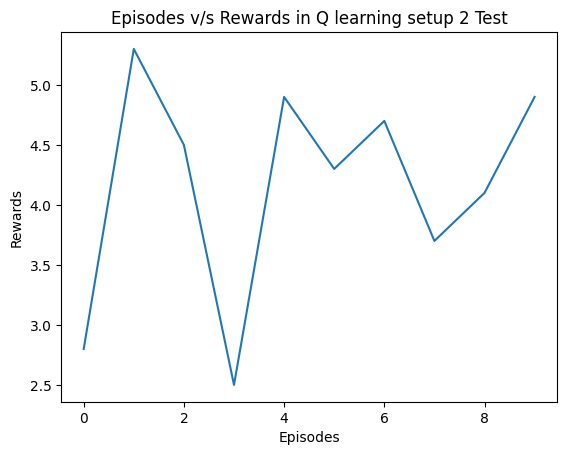

In [ ]:
#Test 2nd implementation Q-learning
import random
def state_to_string(state):
    return ''.join(map(str, state.flatten()))

# Parameters
n_episodes = 10

# Initialize the environment
env = ForestFireEnv()

# Initialize Q-tables for both agents
n_actions = env.action_space.nvec[0]
test_reward2_QL=[]
for episode in range(n_episodes):
    state = env.reset()
    state_str = state_to_string(state)
    state1 = state_str.index('2')
    state2 = state_str.index('3')
    done = False
    total_reward = 0
    count=0
    while not done and count<20:
        count+=1
        # Choose actions for both agents
        action_agent1 = choose_action(q_table_agent1, state1, n_actions, epsilon)
        action_agent2 = choose_action(q_table_agent2, state2, n_actions, epsilon)

        # Take a step in the environment
        next_state, reward, done, _ = env.step([action_agent1, action_agent2])
        if(done):
          break
        next_state_str = state_to_string(next_state)
        
        try:
            next_state1 = next_state_str.index('2')
        except ValueError:
            next_state1 = next_state_str.index('3')
        try:
            next_state2 = next_state_str.index('3')
        except ValueError:
            next_state2 = next_state_str.index('2')
        total_reward += np.sum(reward)
        state1 = next_state1
        state2 = next_state2
        state_str = next_state_str

    test_reward2_QL.append(total_reward)
plt.plot(test_reward2_QL)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes v/s Rewards in Q learning setup 2 Test')
plt.show()    

Streaming output truncated to the last 5000 lines.
Episode 5001, Total reward: 4.499999999999998, epsilon: 0.778312557068642
Episode 5002, Total reward: 5.1, epsilon: 0.778312557068642
Episode 5003, Total reward: 5.1, epsilon: 0.778312557068642
Episode 5004, Total reward: 4.499999999999998, epsilon: 0.778312557068642
Episode 5005, Total reward: 3.6999999999999975, epsilon: 0.778312557068642
Episode 5006, Total reward: 3.6999999999999993, epsilon: 0.778312557068642
Episode 5007, Total reward: 3.099999999999997, epsilon: 0.778312557068642
Episode 5008, Total reward: 3.6999999999999984, epsilon: 0.778312557068642
Episode 5009, Total reward: 4.8999999999999995, epsilon: 0.778312557068642
Episode 5010, Total reward: 5.499999999999999, epsilon: 0.778312557068642
Episode 5011, Total reward: 2.6999999999999975, epsilon: 0.778312557068642
Episode 5012, Total reward: 2.2999999999999963, epsilon: 0.778312557068642
Episode 5013, Total reward: 3.8999999999999986, epsilon: 0.778312557068642
Episode 

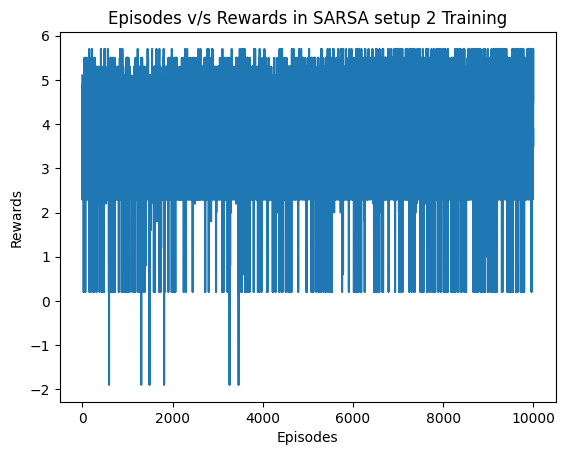

In [ ]:
#Implementation 2 SARSA
import numpy as np
import random
import matplotlib.pyplot as plt

def choose_action(q_table, state_num, n_actions, epsilon):
    if state_num not in q_table:
        q_table[state_num] = np.zeros(n_actions)
    if random.uniform(0, 1) > 1-epsilon:
        return random.randint(0, n_actions - 1)
    else:
        return np.argmax(q_table[state_num])

def update_q_table(q_table, state_num, action, reward, next_state_num, next_action, alpha, gamma):
    if state_num not in q_table:
        q_table[state_num] = np.zeros(n_actions)
    if next_state_num not in q_table:
        q_table[next_state_num] = np.zeros(n_actions)
    td_target = reward + gamma * q_table[next_state_num][next_action]
    td_error = td_target - q_table[state_num][action]
    q_table[state_num][action] += alpha * td_error

def state_to_num(state):
    return state[0] * state[1] + state[2]

# Parameters
n_episodes = 10000
alpha = 0.015  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 1  # Exploration rate

# Initialize the environment
env = ForestFireEnv()

# Initialize Q-tables for both agents
n_actions = env.action_space.nvec[0]
q_table_agent1 = {}
q_table_agent2 = {}
reward_SARSA = []

for episode in range(n_episodes):
    state = env.reset()
    state_num1 = state_to_num(state[0])
    state_num2 = state_to_num(state[1])
    action_agent1 = choose_action(q_table_agent1, state_num1, n_actions, epsilon)
    action_agent2 = choose_action(q_table_agent2, state_num2, n_actions, epsilon)
    done = False
    total_reward = 0
    count = 0
    while not done and count < 20:
        count += 1
        # Take a step in the environment
        next_state, reward, done, _ = env.step([action_agent1, action_agent2])
        if done:
            break
        next_state_num1 = state_to_num(next_state[0])
        next_state_num2 = state_to_num(next_state[1])
        next_action_agent1 = choose_action(q_table_agent1, next_state_num1, n_actions, epsilon)
        next_action_agent2 = choose_action(q_table_agent2, next_state_num2, n_actions, epsilon)

        # Update Q-tables for both agents
        update_q_table(q_table_agent1, state_num1, action_agent1, reward[0], next_state_num1, next_action_agent1, alpha, gamma)
        update_q_table(q_table_agent2, state_num2, action_agent2, reward[1], next_state_num2, next_action_agent2, alpha, gamma)

        total_reward += np.sum(reward)
        state_num1 = next_state_num1
        state_num2 = next_state_num2
        action_agent1 = next_action_agent1
        action_agent2 = next_action_agent2

    reward_SARSA.append(total_reward)
    if (episode + 1) % 100 == 0:
        epsilon *= 0.995
    print(f"Episode {episode + 1}, Total reward: {total_reward}, epsilon: {epsilon}")
plt.plot(reward_SARSA)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes v/s Rewards in SARSA setup 2 Training')
plt.show()


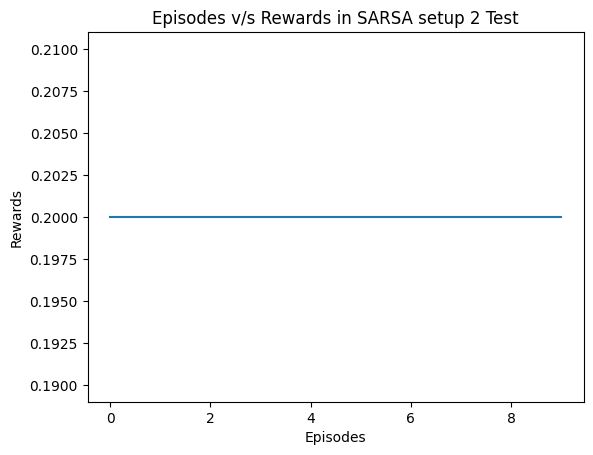

In [ ]:
#Test Implementation 2 SARSA
def state_to_num(state):
    return state[0] * state[1] + state[2]

# Parameters
n_episodes = 10 
# Initialize the environment
env = ForestFireEnv()

# Initialize Q-tables for both agents
n_actions = env.action_space.nvec[0]
test2_reward_SARSA = []

for episode in range(n_episodes):
    state = env.reset()
    state_num1 = state_to_num(state[0])
    state_num2 = state_to_num(state[1])
    action_agent1 = choose_max_action(q_table_agent1, state_num1, n_actions, epsilon)
    action_agent2 = choose_max_action(q_table_agent2, state_num2, n_actions, epsilon)
    done = False
    total_reward = 0
    count = 0
    while not done and count < 20:
        count += 1
        # Take a step in the environment
        next_state, reward, done, _ = env.step([action_agent1, action_agent2])
        if done:
            break
        next_state_num1 = state_to_num(next_state[0])
        next_state_num2 = state_to_num(next_state[1])
        next_action_agent1 = choose_max_action(q_table_agent1, next_state_num1, n_actions, epsilon)
        next_action_agent2 = choose_max_action(q_table_agent2, next_state_num2, n_actions, epsilon)
        total_reward += np.sum(reward)
        state_num1 = next_state_num1
        state_num2 = next_state_num2
        action_agent1 = next_action_agent1
        action_agent2 = next_action_agent2

    test2_reward_SARSA.append(total_reward)
plt.plot(test2_reward_SARSA)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Episodes v/s Rewards in SARSA setup 2 Test')
plt.show()

# DQN & DDQN Custom env deterministic

In [ ]:
import gym
import numpy as np
from PIL import Image
from gym import spaces
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class ForestFireEnv(gym.Env):

    def __init__(self, grid_size=3, max_steps=100):
        super(ForestFireEnv, self).__init__()
        tree_image = Image.open("tree.png")
        fire_image = Image.open("fire.png")
        agent_image = Image.open("agent.png")

        # Scale the images to fit the cell size
        cell_size = 32  # Define the size of each cell
        self.tree_image = tree_image.resize((cell_size, cell_size))
        self.fire_image = fire_image.resize((cell_size, cell_size))
        self.agent_image = agent_image.resize((cell_size, cell_size))
        self.cell_size = 32

        self.grid_size = grid_size
        self.max_steps = max_steps
        self.current_step = 0
        self.action_space = spaces.MultiDiscrete([4, 4])  # Two agents, each can move in 4 directions: up, down, left, right
        self.observation_space = spaces.Box(low=0, high=2, shape=(grid_size, grid_size), dtype=np.uint8)

        self.reset()

    def reset(self):
        self.current_step = 0
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        self.agent_positions = [(0, 0), (self.grid_size - 1, self.grid_size - 1)]
        self.visited_cells = set(self.agent_positions)
        self.grid[self.agent_positions[0]] = 2
        self.grid[self.agent_positions[1]] = 3
        fires =[[1,1],[0,2],[2,1],[2,0]]
        for (x,y) in fires :
          self.grid[x,y] = 1
        return self.grid

    def step(self, action):
        self.current_step += 1
        rewards = [0] * len(self.agent_positions)

        for i, act in enumerate(action):
            x, y = self.agent_positions[i]
            if act == 0:    # Move up
                x = max(x - 1, 0)
            elif act == 1:  # Move down
                x = min(x + 1, self.grid_size - 1)
            elif act == 2:  # Move left
                y = max(y - 1, 0)
            elif act == 3:  # Move right
                y = min(y + 1, self.grid_size - 1)
            
            self.grid[self.agent_positions[i]] = 0
            self.agent_positions[i] = (x, y)
            self.visited_cells.add((x, y))
            
            # Put out fire if agent is on a cell with fire
            if self.grid[x, y] == 1:
                self.grid[x, y] = 0
                rewards[i] += 5  # Reward for putting out fire
            else:
                rewards[i] -= 1  # Penalty for visiting a cell without fire

        self.grid[self.agent_positions[0]] = 2
        self.grid[self.agent_positions[1]] = 3
        done = not np.any(self.grid == 1) or self.current_step >= self.max_steps  # Episode is done when there are no fires left or max_steps reached

        info = {
            'agent_positions': self.agent_positions,
            'visited_cells': self.visited_cells,
            'current_step': self.current_step
        }

        return self.grid, rewards, done, info

    def render(self, mode='human'):
        if mode == 'rgb_array':
            return self._get_rgb_array()
        else:
            self._show_plot()

    def _get_rgb_array(self):
        # Create a canvas for the images
        canvas = Image.new('RGB', (self.grid_size * self.cell_size, self.grid_size * self.cell_size), (255, 255, 255))

        # Draw the images on the canvas
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                position = (y * self.cell_size, x * self.cell_size)

                if self.grid[x, y] == 1:
                    canvas.paste(self.fire_image, position, self.fire_image if self.fire_image.mode == 'RGBA' else None)
                else:
                    canvas.paste(self.tree_image, position, self.tree_image if self.tree_image.mode == 'RGBA' else None)

                if (x, y) in self.agent_positions:
                    canvas.paste(self.agent_image, position, self.agent_image if self.agent_image.mode == 'RGBA' else None)

        return np.array(canvas)

    def _show_plot(self):
        plt.clf()  # Clear the previous plot

        # Display the canvas using matplotlib
        plt.imshow(self._get_rgb_array())
        plt.xticks(range(0, self.grid_size * self.cell_size, self.cell_size))
        plt.yticks(range(0, self.grid_size * self.cell_size, self.cell_size))
        plt.grid(True, linestyle='-', linewidth=0.5)

        plt.draw()
        plt.pause(0.5)
        plt.show(block=False)



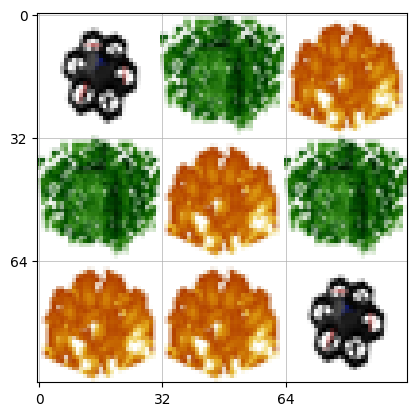

In [ ]:
env = ForestFireEnv()
env.render()

DQN 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class DQNAgent:
    def __init__(self, state_size, action_size, device, lr=0.001, gamma=0.99, buffer_size=10000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.lr = lr
        self.gamma = gamma
        self.batch_size = batch_size

        self.memory = deque(maxlen=buffer_size)
        self.model = self._build_model().to(device)
        self.target_model = self._build_model().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.update_target_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            return self.model(state).argmax().item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float32, device=self.device)

        current_q_values = self.model(states).gather(1, actions)
        next_q_values = self.target_model(next_states).max(1)[0].detach()
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(current_q_values, target_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


def train_dqn(agents, env, episodes=1000, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, update_frequency=100, early_stopping_patience=50, reward_threshold=15):
    state_size = env.observation_space.shape[0] * env.observation_space.shape[1]
    action_size = env.action_space.nvec[0]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    rewards_history = []
    best_average_reward = float('-inf')
    no_improvement_count = 0

    epsilon = epsilon_start

    for episode in range(episodes):
        state = env.reset().flatten()
        done = False
        total_rewards = [0, 0]

        while not done:
            actions = [agent.choose_action(state, epsilon) for agent in agents]
            next_state, rewards, done, _ = env.step(actions)
            next_state = next_state.flatten()

            for i, agent in enumerate(agents):
                agent.remember(state, actions[i], rewards[i], next_state, done)

            state = next_state
            total_rewards = [total_rewards[i] + rewards[i] for i in range(len(rewards))]

            for agent in agents:
                agent.train()

        if episode % update_frequency == 0:
            for agent in agents:
                agent.update_target_model()

        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        rewards_history.append(total_rewards)

        print(f"Episode {episode + 1}/{episodes} - Agent 1 Reward: {total_rewards[0]}, Agent 2 Reward: {total_rewards[1]}, Epsilon: {epsilon}")

        # Early stopping
        if episode >= early_stopping_patience:
            recent_average_reward = np.mean([r[0] + r[1] for r in rewards_history[-early_stopping_patience:]])
            if recent_average_reward > best_average_reward:
                best_average_reward = recent_average_reward
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if recent_average_reward >= reward_threshold or no_improvement_count >= early_stopping_patience:
                print(f"Early stopping after {episode + 1} episodes")
                break

    return rewards_history



# Train the DQN agents
agents = [DQNAgent(state_size=9, action_size=4, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")) for _ in range(2)]
env = ForestFireEnv(grid_size=3)
rewards_history = train_dqn(agents, env)



Episode 1/1000 - Agent 1 Reward: -8, Agent 2 Reward: -20, Epsilon: 0.995
Episode 2/1000 - Agent 1 Reward: 0, Agent 2 Reward: 12, Epsilon: 0.990025
Episode 3/1000 - Agent 1 Reward: -10, Agent 2 Reward: 14, Epsilon: 0.985074875
Episode 4/1000 - Agent 1 Reward: 2, Agent 2 Reward: -22, Epsilon: 0.9801495006250001
Episode 5/1000 - Agent 1 Reward: -42, Agent 2 Reward: -30, Epsilon: 0.9752487531218751
Episode 6/1000 - Agent 1 Reward: -17, Agent 2 Reward: -5, Epsilon: 0.9703725093562657
Episode 7/1000 - Agent 1 Reward: -7, Agent 2 Reward: -7, Epsilon: 0.9655206468094844
Episode 8/1000 - Agent 1 Reward: -3, Agent 2 Reward: -3, Epsilon: 0.960693043575437
Episode 9/1000 - Agent 1 Reward: 1, Agent 2 Reward: -11, Epsilon: 0.9558895783575597
Episode 10/1000 - Agent 1 Reward: -36, Agent 2 Reward: -36, Epsilon: 0.9511101304657719
Episode 11/1000 - Agent 1 Reward: -24, Agent 2 Reward: -12, Epsilon: 0.946354579813443
Episode 12/1000 - Agent 1 Reward: 6, Agent 2 Reward: 6, Epsilon: 0.9416228069143757
Epi

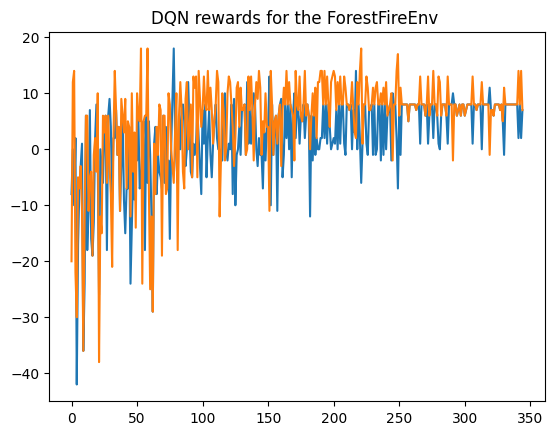

In [ ]:
plt.plot(rewards_history)
plt.title("DQN rewards for the ForestFireEnv ")
plt.show() 

Episode 1/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 2/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 3/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 4/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 5/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 6/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 7/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 8/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 9/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 10/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4


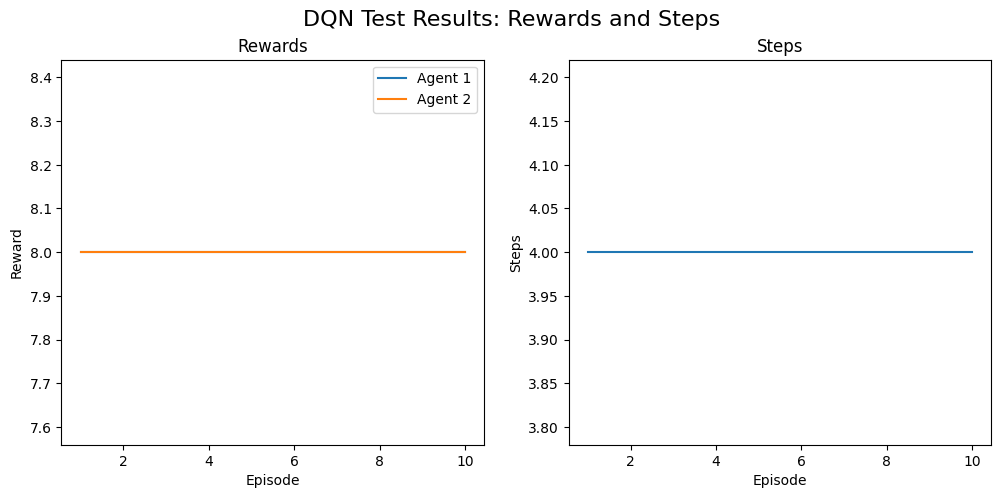

In [ ]:
def test_dqn(agents, env, episodes=10):
    rewards_history = []
    steps_history = []

    for episode in range(episodes):
        state = env.reset().flatten()
        done = False
        total_rewards = [0, 0]
        step_count = 0
        while not done:
            step_count += 1
            # env.render()
            actions = [agent.choose_action(state, 0) for agent in agents]  # Epsilon is set to 0 for testing (no exploration)
            next_state, rewards, done, _ = env.step(actions)
            next_state = next_state.flatten()
            state = next_state
            total_rewards = [total_rewards[i] + rewards[i] for i in range(len(rewards))]
        print(f"Episode {episode + 1}/{episodes} - Agent 1 Reward: {total_rewards[0]}, Agent 2 Reward: {total_rewards[1]}, Steps: {step_count}")
        rewards_history.append(total_rewards)
        steps_history.append(step_count)
    env.close()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))    
    ax1.plot(range(1, episodes + 1), [r[0] for r in rewards_history], label="Agent 1")
    ax1.plot(range(1, episodes + 1), [r[1] for r in rewards_history], label="Agent 2")
    ax1.set_title("Rewards")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Reward")
    ax1.legend()

    ax2.plot(range(1, episodes + 1), steps_history)
    ax2.set_title("Steps")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Steps")
    fig.suptitle("DQN Test Results: Rewards and Steps", fontsize=16)
    plt.show()

test_dqn(agents, env)


DDQN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class DDQNAgent:
    def __init__(self, state_size, action_size, device, lr=0.001, gamma=0.99, buffer_size=10000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.lr = lr
        self.gamma = gamma
        self.batch_size = batch_size

        self.memory = deque(maxlen=buffer_size)
        self.model = self._build_model().to(device)
        self.target_model = self._build_model().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.update_target_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            return self.model(state).argmax().item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())


    def train(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float32, device=self.device)

        current_q_values = self.model(states).gather(1, actions)

        # Use online model to select actions
        online_next_actions = self.model(next_states).argmax(1).unsqueeze(1)
        # Use target model to evaluate actions
        next_q_values = self.target_model(next_states).gather(1, online_next_actions).squeeze(1).detach()
        
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(current_q_values, target_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



def train_ddqn(agents, env, episodes=1000, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, update_frequency=100):
    state_size = env.observation_space.shape[0] * env.observation_space.shape[1]
    action_size = env.action_space.nvec[0]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    rewards_history = []

    epsilon = epsilon_start

    for episode in range(episodes):
        state = env.reset().flatten()
        done = False
        total_rewards = [0, 0]

        while not done:
            actions = [agent.choose_action(state, epsilon) for agent in agents]
            next_state, rewards, done, _ = env.step(actions)
            next_state = next_state.flatten()

            for i, agent in enumerate(agents):
                agent.remember(state, actions[i], rewards[i], next_state, done)

            state = next_state
            total_rewards = [total_rewards[i] + rewards[i] for i in range(len(rewards))]

            for agent in agents:
                agent.train()

        if episode % update_frequency == 0:
            for agent in agents:
                agent.update_target_model()

        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        rewards_history.append(total_rewards)

        print(f"Episode {episode + 1}/{episodes} - Agent 1 Reward: {total_rewards[0]}, Agent 2 Reward: {total_rewards[1]}, Epsilon: {epsilon}")

    return rewards_history


# Train the DQN agents
agents = [DDQNAgent(state_size=9, action_size=4, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")) for _ in range(2)]
env = ForestFireEnv(grid_size=3)
rewards_history = train_ddqn(agents, env)



Episode 1/1000 - Agent 1 Reward: -34, Agent 2 Reward: -34, Epsilon: 0.995
Episode 2/1000 - Agent 1 Reward: -19, Agent 2 Reward: -7, Epsilon: 0.990025
Episode 3/1000 - Agent 1 Reward: 4, Agent 2 Reward: 4, Epsilon: 0.985074875
Episode 4/1000 - Agent 1 Reward: -5, Agent 2 Reward: 7, Epsilon: 0.9801495006250001
Episode 5/1000 - Agent 1 Reward: 10, Agent 2 Reward: -2, Epsilon: 0.9752487531218751
Episode 6/1000 - Agent 1 Reward: -1, Agent 2 Reward: -1, Epsilon: 0.9703725093562657
Episode 7/1000 - Agent 1 Reward: -9, Agent 2 Reward: -33, Epsilon: 0.9655206468094844
Episode 8/1000 - Agent 1 Reward: -18, Agent 2 Reward: -18, Epsilon: 0.960693043575437
Episode 9/1000 - Agent 1 Reward: 5, Agent 2 Reward: -7, Epsilon: 0.9558895783575597
Episode 10/1000 - Agent 1 Reward: -6, Agent 2 Reward: 6, Epsilon: 0.9511101304657719
Episode 11/1000 - Agent 1 Reward: -5, Agent 2 Reward: -5, Epsilon: 0.946354579813443
Episode 12/1000 - Agent 1 Reward: -35, Agent 2 Reward: -23, Epsilon: 0.9416228069143757
Episod

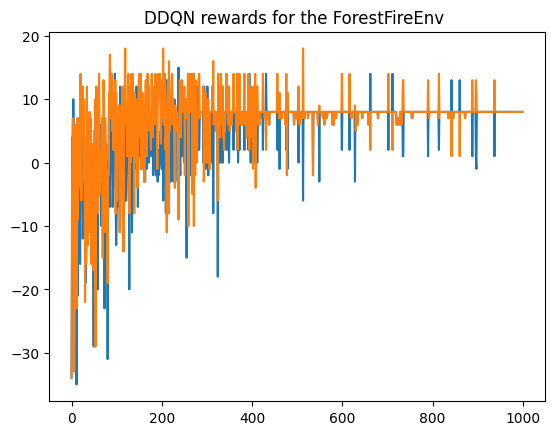

In [ ]:
plt.plot(rewards_history)
plt.title("DDQN rewards for the ForestFireEnv ")
plt.show() 

Episode 1/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 2/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 3/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 4/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 5/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 6/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 7/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 8/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 9/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4
Episode 10/10 - Agent 1 Reward: 8, Agent 2 Reward: 8, Steps: 4


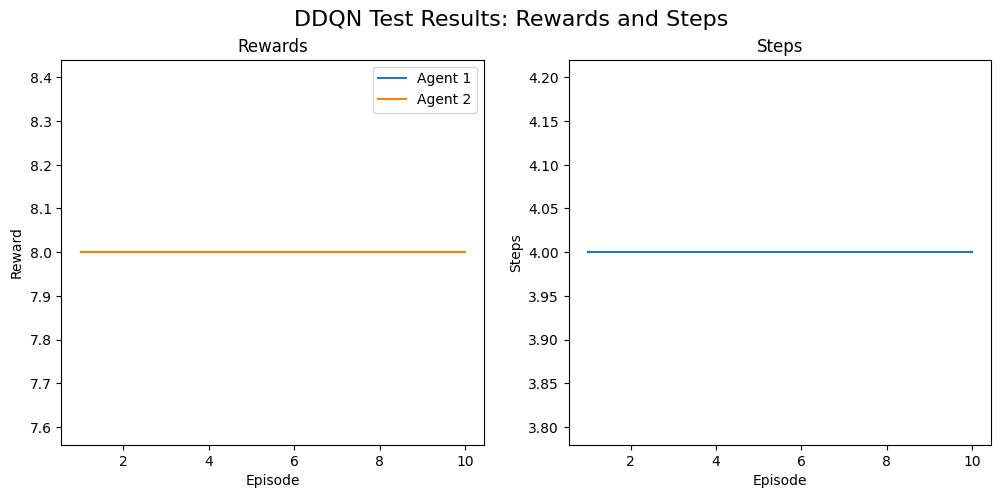

In [ ]:
def test_ddqn(agents, env, episodes=10):
    rewards_history = []
    steps_history = []

    for episode in range(episodes):
        state = env.reset().flatten()
        done = False
        total_rewards = [0, 0]
        step_count = 0
        while not done:
            step_count += 1
            # env.render()
            actions = [agent.choose_action(state, 0) for agent in agents]  # Epsilon is set to 0 for testing (no exploration)
            next_state, rewards, done, _ = env.step(actions)
            next_state = next_state.flatten()
            state = next_state
            total_rewards = [total_rewards[i] + rewards[i] for i in range(len(rewards))]
        print(f"Episode {episode + 1}/{episodes} - Agent 1 Reward: {total_rewards[0]}, Agent 2 Reward: {total_rewards[1]}, Steps: {step_count}")
        rewards_history.append(total_rewards)
        steps_history.append(step_count)
    env.close()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))    
    ax1.plot(range(1, episodes + 1), [r[0] for r in rewards_history], label="Agent 1")
    ax1.plot(range(1, episodes + 1), [r[1] for r in rewards_history], label="Agent 2")
    ax1.set_title("Rewards")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Reward")
    ax1.legend()

    ax2.plot(range(1, episodes + 1), steps_history)
    ax2.set_title("Steps")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Steps")
    fig.suptitle("DDQN Test Results: Rewards and Steps", fontsize=16)
    plt.show()

test_ddqn(agents, env)


# DQN & DDQN Custom env stochastic

In [ ]:
import gym
import numpy as np
from gym import spaces
from PIL import Image
import matplotlib.pyplot as plt

class ForestFireEnv(gym.Env):
    def __init__(self, grid_size=6, p_fire=0.1, p_spread=0.02, max_steps=1000):
        super(ForestFireEnv, self).__init__()
        tree_image = Image.open("tree.png")
        fire_image = Image.open("fire.png")
        agent_image = Image.open("agent.png")

        cell_size = 32
        self.tree_image = tree_image.resize((cell_size, cell_size))
        self.fire_image = fire_image.resize((cell_size, cell_size))
        self.agent_image = agent_image.resize((cell_size, cell_size))
        self.cell_size = 32

        self.grid_size = grid_size
        self.p_fire = p_fire
        self.p_spread = p_spread

        self.max_steps = max_steps
        self.current_step = 0
        self.fig, self.ax = plt.subplots()
        self.action_space = spaces.MultiDiscrete([4] * 2)  
        self.observation_space = spaces.Tuple([spaces.Box(low=0, high=2, shape=(grid_size, grid_size), dtype=np.uint8)] * 2)


        self.reset()

    def reset(self):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        self.agent_positions = [(0, 0), (self.grid_size - 1, self.grid_size - 1)]
        self.visited_cells = set(self.agent_positions)

        fires = np.random.rand(self.grid_size, self.grid_size) < self.p_fire
        self.grid[fires] = 1

        return [self.grid.flatten()] * 2


    def step(self, action):
        rewards = [0, 0]
        self.current_step += 1
        for i, act in enumerate(action):
            x, y = self.agent_positions[i]
            if act == 0:    # Move up
                x = max(x - 1, 0)
            elif act == 1:  # Move down
                x = min(x + 1, self.grid_size - 1)
            elif act == 2:  # Move left
                y = max(y - 1, 0)
            elif act == 3:  # Move right
                y = min(y + 1, self.grid_size - 1)

            self.agent_positions[i] = (x, y)
            self.visited_cells.add((x, y))

            if self.grid[x, y] == 1:
                self.grid[x, y] = 0
                rewards[i] += 1
            else:
                rewards[i] += 0.01

        new_fires = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        fire_spread = False
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                if self.grid[x, y] == 1:
                    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size and self.grid[nx, ny] == 0:
                            if np.random.rand() < self.p_spread and (nx, ny) not in self.visited_cells:
                                new_fires[nx, ny] = 1
                                fire_spread = True

        if fire_spread:
            rewards[i] -= 0.1

        self.grid = np.maximum(self.grid, new_fires)

        done = not np.any(self.grid == 1) or self.current_step >= self.max_steps # Episode is done when there are no fires left

        return [self.grid.flatten()] * 2, rewards, done, {}

    def render(self, mode='human'):
        plt.clf()  # Clear the previous plot

        canvas = Image.new('RGB', (self.grid_size * self.cell_size, self.grid_size * self.cell_size), (255, 255, 255))

        for x in range(self.grid_size):
            for y in range(self.grid_size):
                position = (y * self.cell_size, x * self.cell_size)

                if self.grid[x, y] == 1:
                    canvas.paste(self.fire_image, position, self.fire_image if self.fire_image.mode == 'RGBA' else None)
                else:
                    canvas.paste(self.tree_image, position, self.tree_image if self.tree_image.mode == 'RGBA' else None)

                if (x, y) in self.agent_positions:
                    canvas.paste(self.agent_image, position, self.agent_image if self.agent_image.mode == 'RGBA' else None)

        plt.imshow(np.array(canvas))
        plt.xticks(range(0, self.grid_size * self.cell_size, self.cell_size))
        plt.yticks(range(0, self.grid_size * self.cell_size, self.cell_size))
        plt.grid(True, linestyle='-', linewidth=0.5)

        plt.draw()
        plt.pause(0.5)
        plt.show(block=False)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


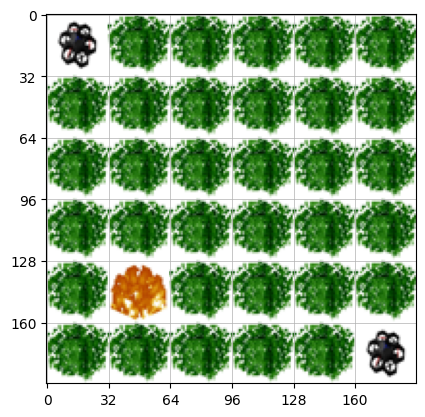

In [ ]:
env=ForestFireEnv()
env.render()

DQN

Episode: 0, Rewards: [3.6999999999999904, 5.17999999999999], Epsilon: 0.995


<ipython-input-32-d19f9999963c>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)


Episode: 10, Rewards: [2.4399999999999986, 1.05], Epsilon: 0.946354579813443
Episode: 20, Rewards: [0.01, 0.01], Epsilon: 0.9000874278732445
Episode: 30, Rewards: [0.01, 0.01], Epsilon: 0.8560822709551227
Episode: 40, Rewards: [0.01, 0.01], Epsilon: 0.8142285204175609
Episode: 50, Rewards: [0.01, -0.09000000000000001], Epsilon: 0.7744209942832988
Episode: 60, Rewards: [0.01, 0.01], Epsilon: 0.736559652908221
Episode: 70, Rewards: [0.01, 0.01], Epsilon: 0.7005493475733617
Episode: 80, Rewards: [0.01, 0.01], Epsilon: 0.6662995813682115
Episode: 90, Rewards: [0.01, 1], Epsilon: 0.6337242817644086
Episode: 100, Rewards: [0.01, 0.01], Epsilon: 0.6027415843082742
Episode: 110, Rewards: [0.01, 0.01], Epsilon: 0.5732736268885887
Episode: 120, Rewards: [0.01, 0.01], Epsilon: 0.5452463540625918
Episode: 130, Rewards: [0.01, -0.09000000000000001], Epsilon: 0.5185893309484582
Episode: 140, Rewards: [0.01, 0.01], Epsilon: 0.4932355662165453
Episode: 150, Rewards: [0.01, 0.01], Epsilon: 0.4691213437

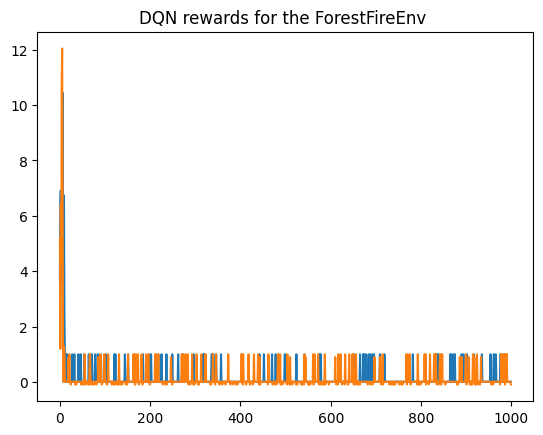

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class DQNAgent:
    def __init__(self, state_size, action_size, device, lr=0.001, gamma=0.99, buffer_size=10000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.lr = lr
        self.gamma = gamma
        self.batch_size = batch_size

        self.memory = deque(maxlen=buffer_size)
        self.model = self._build_model().to(device)
        self.target_model = self._build_model().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.update_target_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            return self.model(state).argmax().item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float32, device=self.device)

        current_q_values = self.model(states).gather(1, actions)
        next_q_values = self.target_model(next_states).max(1)[0].detach()
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(current_q_values, target_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


def train_dqn(agents, env, episodes=1000, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, update_frequency=100):
    state_size = env.observation_space[0].shape[0] * env.observation_space[0].shape[1]
    action_size = env.action_space.nvec[0]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    epsilon = epsilon_start
    
    rewards_history = []

    for episode in range(episodes):
        states = env.reset()
        done = False
        total_rewards = [0, 0]

        while not done:
            actions = []
            for i, agent in enumerate(agents):
                state_tensor = torch.FloatTensor(states[i]).to(device)
                action = agent.choose_action(state_tensor, epsilon)
                actions.append(action)

            next_states, rewards, done, _ = env.step(actions)
            next_states = [next_state.flatten() for next_state in next_states]

            for i, agent in enumerate(agents):
                agent.remember(states[i], actions[i], rewards[i], next_states[i], done)

                total_rewards[i] += rewards[i]

            states = next_states

        rewards_history.append(total_rewards)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        if episode % update_frequency == 0:
            for agent in agents:
                agent.update_target_model()

        if episode % 10 == 0:
            print(f"Episode: {episode}, Rewards: {total_rewards}, Epsilon: {epsilon}")

    return rewards_history


# Train the DQN agents
agents = [DQNAgent(state_size=36, action_size=4, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")) for _ in range(2)]
env = ForestFireEnv(grid_size=6)
rewards_history = train_dqn(agents, env)
plt.plot(rewards_history)
plt.title("DQN rewards for the ForestFireEnv ")
plt.show() 


<ipython-input-32-d19f9999963c>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)


Test Episode: 0, Rewards: [1, 0.01]
Test Episode: 10, Rewards: [0.01, 1]
Test Episode: 20, Rewards: [0.01, -0.09000000000000001]
Test Episode: 30, Rewards: [0.01, 0.01]
Test Episode: 40, Rewards: [1, -0.09000000000000001]
Test Episode: 50, Rewards: [0.01, -0.09000000000000001]
Test Episode: 60, Rewards: [0.01, 1]
Test Episode: 70, Rewards: [0.01, 0.01]
Test Episode: 80, Rewards: [1, 0.01]
Test Episode: 90, Rewards: [0.01, 0.01]


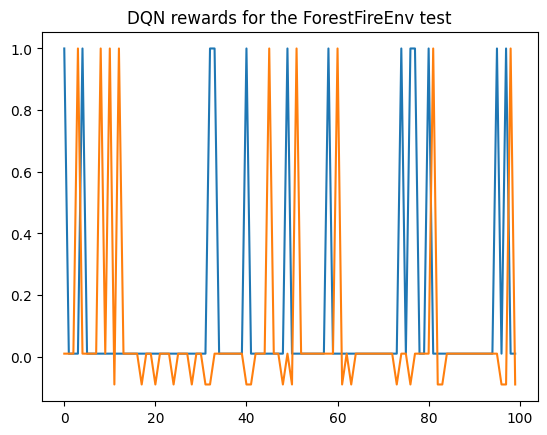

In [ ]:
def test_dqn(agents, env, episodes=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    rewards_history_test = []

    for episode in range(episodes):
        states = env.reset()
        done = False
        total_rewards = [0, 0]

        while not done:
            actions = []
            for i, agent in enumerate(agents):
                state_tensor = torch.FloatTensor(states[i]).to(device)
                action = agent.choose_action(state_tensor, epsilon=0)  # Set epsilon to 0 for no exploration
                actions.append(action)

            next_states, rewards, done, _ = env.step(actions)
            next_states = [next_state.flatten() for next_state in next_states]

            for i, agent in enumerate(agents):
                total_rewards[i] += rewards[i]

            states = next_states

        rewards_history_test.append(total_rewards)

        if episode % 10 == 0:
            print(f"Test Episode: {episode}, Rewards: {total_rewards}")

    return rewards_history_test

# Test the trained DQN agents
test_rewards = test_dqn(agents, env, episodes=100)

plt.plot(test_rewards)
plt.title("DQN rewards for the ForestFireEnv test")
plt.show()


DDQN

Episode: 0, Rewards: [2.25, 0.17], Epsilon: 0.995
Episode: 10, Rewards: [2.05, 0.07], Epsilon: 0.946354579813443
Episode: 20, Rewards: [2.2700000000000005, 0.2900000000000001], Epsilon: 0.9000874278732445


<ipython-input-34-0410faf065da>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)


Episode: 30, Rewards: [1.1700000000000002, 1.17], Epsilon: 0.8560822709551227
Episode: 40, Rewards: [0.01, 0.01], Epsilon: 0.8142285204175609
Episode: 50, Rewards: [2.3199999999999976, 1.9200000000000004], Epsilon: 0.7744209942832988
Episode: 60, Rewards: [0.01, 0.01], Epsilon: 0.736559652908221
Episode: 70, Rewards: [0.01, 0.01], Epsilon: 0.7005493475733617
Episode: 80, Rewards: [0.01, 0.01], Epsilon: 0.6662995813682115
Episode: 90, Rewards: [0.01, 0.01], Epsilon: 0.6337242817644086
Episode: 100, Rewards: [0.01, 0.01], Epsilon: 0.6027415843082742
Episode: 110, Rewards: [0.01, 0.01], Epsilon: 0.5732736268885887
Episode: 120, Rewards: [0.01, 0.01], Epsilon: 0.5452463540625918
Episode: 130, Rewards: [0.01, 0.01], Epsilon: 0.5185893309484582
Episode: 140, Rewards: [0.01, 0.01], Epsilon: 0.4932355662165453
Episode: 150, Rewards: [0.01, 1], Epsilon: 0.46912134373457726
Episode: 160, Rewards: [0.01, 0.01], Epsilon: 0.446186062443672
Episode: 170, Rewards: [0.01, 0.01], Epsilon: 0.42437208406

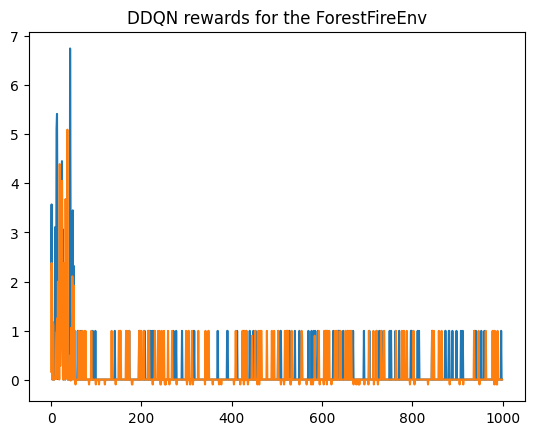

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class DDQNAgent:
    def __init__(self, state_size, action_size, device, lr=0.001, gamma=0.99, buffer_size=10000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.lr = lr
        self.gamma = gamma
        self.batch_size = batch_size

        self.memory = deque(maxlen=buffer_size)
        self.model = self._build_model().to(device)
        self.target_model = self._build_model().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.update_target_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            return self.model(state).argmax().item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())


    def train(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float32, device=self.device)

        current_q_values = self.model(states).gather(1, actions)

        # Use online model to select actions
        online_next_actions = self.model(next_states).argmax(1).unsqueeze(1)
        # Use target model to evaluate actions
        next_q_values = self.target_model(next_states).gather(1, online_next_actions).squeeze(1).detach()
        
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(current_q_values, target_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



def train_ddqn(agents, env, episodes=1000, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, update_frequency=100):
    state_size = env.observation_space[0].shape[0] * env.observation_space[0].shape[1]
    action_size = env.action_space.nvec[0]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    epsilon = epsilon_start
    
    rewards_history = []

    for episode in range(episodes):
        states = env.reset()
        done = False
        total_rewards = [0, 0]

        while not done:
            actions = []
            for i, agent in enumerate(agents):
                state_tensor = torch.FloatTensor(states[i]).to(device)
                action = agent.choose_action(state_tensor, epsilon)
                actions.append(action)

            next_states, rewards, done, _ = env.step(actions)
            next_states = [next_state.flatten() for next_state in next_states]

            for i, agent in enumerate(agents):
                agent.remember(states[i], actions[i], rewards[i], next_states[i], done)

                total_rewards[i] += rewards[i]

            states = next_states

        rewards_history.append(total_rewards)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        if episode % update_frequency == 0:
            for agent in agents:
                agent.update_target_model()

        if episode % 10 == 0:
            print(f"Episode: {episode}, Rewards: {total_rewards}, Epsilon: {epsilon}")

    return rewards_history



# Train the DDQN agents
agents = [DDQNAgent(state_size=16, action_size=4, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")) for _ in range(2)]
env = ForestFireEnv(grid_size=4)
rewards_history = train_ddqn(agents, env)
plt.plot(rewards_history)
plt.title("DDQN rewards for the ForestFireEnv")
plt.show() 

<ipython-input-34-0410faf065da>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)


Test Episode: 0, Rewards: [0.01, 0.01]
Test Episode: 10, Rewards: [0.01, 0.01]
Test Episode: 20, Rewards: [0.01, 0.01]
Test Episode: 30, Rewards: [0.01, 0.01]
Test Episode: 40, Rewards: [0.01, 0.01]
Test Episode: 50, Rewards: [0.01, 1]
Test Episode: 60, Rewards: [0.01, 0.01]
Test Episode: 70, Rewards: [0.01, 0.01]
Test Episode: 80, Rewards: [0.01, 0.01]
Test Episode: 90, Rewards: [0.01, 0.01]


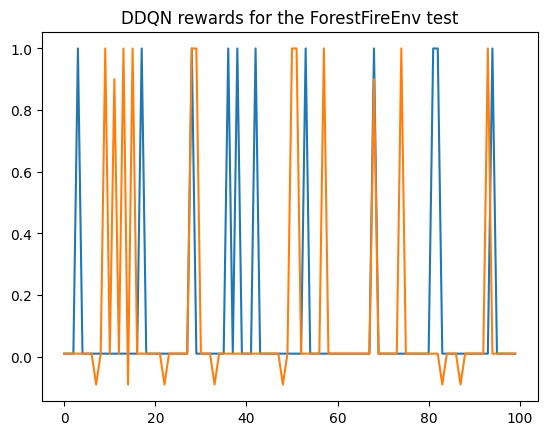

In [ ]:
def test_ddqn(agents, env, episodes=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    rewards_history_test = []

    for episode in range(episodes):
        states = env.reset()
        done = False
        total_rewards = [0, 0]

        while not done:
            actions = []
            for i, agent in enumerate(agents):
                state_tensor = torch.FloatTensor(states[i]).to(device)
                action = agent.choose_action(state_tensor, epsilon=0)  # Set epsilon to 0 for no exploration
                actions.append(action)

            next_states, rewards, done, _ = env.step(actions)
            next_states = [next_state.flatten() for next_state in next_states]

            for i, agent in enumerate(agents):
                total_rewards[i] += rewards[i]

            states = next_states

        rewards_history_test.append(total_rewards)

        if episode % 10 == 0:
            print(f"Test Episode: {episode}, Rewards: {total_rewards}")

    return rewards_history_test

# Test the trained DDQN agents
test_rewards = test_ddqn(agents, env, episodes=100)

plt.plot(test_rewards)
plt.title("DDQN rewards for the ForestFireEnv test")
plt.show()


# A2C- advantage actor_critic on ForestFire env (Deterministic)

In [ ]:
import gym
import numpy as np
from PIL import Image
from gym import spaces
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class ForestFireEnv(gym.Env):

    def __init__(self, grid_size=3, max_steps=100):
        super(ForestFireEnv, self).__init__()
        tree_image = Image.open("tree.png")
        fire_image = Image.open("fire.png")
        agent_image = Image.open("agent.png")

        # Scale the images to fit the cell size
        cell_size = 32  # Define the size of each cell
        self.tree_image = tree_image.resize((cell_size, cell_size))
        self.fire_image = fire_image.resize((cell_size, cell_size))
        self.agent_image = agent_image.resize((cell_size, cell_size))
        self.cell_size = 32

        self.grid_size = grid_size
        self.max_steps = max_steps
        self.current_step = 0
        self.action_space = spaces.MultiDiscrete([4, 4])  # Two agents, each can move in 4 directions: up, down, left, right
        self.observation_space = spaces.Box(low=0, high=2, shape=(grid_size, grid_size), dtype=np.uint8)

        self.reset()

    def reset(self):
        self.current_step = 0
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        self.agent_positions = [(0, 0), (self.grid_size - 1, self.grid_size - 1)]
        self.visited_cells = set(self.agent_positions)
        self.grid[self.agent_positions[0]] = 2
        self.grid[self.agent_positions[1]] = 3
        fires =[[1,1],[0,2],[2,1],[2,0]]
        for (x,y) in fires :
          self.grid[x,y] = 1
        return self.grid

    def step(self, action):
        self.current_step += 1
        rewards = [0] * len(self.agent_positions)

        for i, act in enumerate(action):
            x, y = self.agent_positions[i]
            if act == 0:    # Move up
                x = max(x - 1, 0)
            elif act == 1:  # Move down
                x = min(x + 1, self.grid_size - 1)
            elif act == 2:  # Move left
                y = max(y - 1, 0)
            elif act == 3:  # Move right
                y = min(y + 1, self.grid_size - 1)
            
            self.grid[self.agent_positions[i]] = 0
            self.agent_positions[i] = (x, y)
            self.visited_cells.add((x, y))
            
            # Put out fire if agent is on a cell with fire
            if self.grid[x, y] == 1:
                self.grid[x, y] = 0
                rewards[i] += 5  # Reward for putting out fire
            else:
                rewards[i] -= 1  # Penalty for visiting a cell without fire

        self.grid[self.agent_positions[0]] = 2
        self.grid[self.agent_positions[1]] = 3
        done = not np.any(self.grid == 1) or self.current_step >= self.max_steps  # Episode is done when there are no fires left or max_steps reached

        info = {
            'agent_positions': self.agent_positions,
            'visited_cells': self.visited_cells,
            'current_step': self.current_step
        }

        return self.grid, rewards, done, info

    def render(self, mode='human'):
        if mode == 'rgb_array':
            return self._get_rgb_array()
        else:
            self._show_plot()

    def _get_rgb_array(self):
        # Create a canvas for the images
        canvas = Image.new('RGB', (self.grid_size * self.cell_size, self.grid_size * self.cell_size), (255, 255, 255))

        # Draw the images on the canvas
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                position = (y * self.cell_size, x * self.cell_size)

                if self.grid[x, y] == 1:
                    canvas.paste(self.fire_image, position, self.fire_image if self.fire_image.mode == 'RGBA' else None)
                else:
                    canvas.paste(self.tree_image, position, self.tree_image if self.tree_image.mode == 'RGBA' else None)

                if (x, y) in self.agent_positions:
                    canvas.paste(self.agent_image, position, self.agent_image if self.agent_image.mode == 'RGBA' else None)

        return np.array(canvas)

    def _show_plot(self):
        plt.clf()  # Clear the previous plot

        # Display the canvas using matplotlib
        plt.imshow(self._get_rgb_array())
        plt.xticks(range(0, self.grid_size * self.cell_size, self.cell_size))
        plt.yticks(range(0, self.grid_size * self.cell_size, self.cell_size))
        plt.grid(True, linestyle='-', linewidth=0.5)

        plt.draw()
        plt.pause(0.5)
        plt.show(block=False)



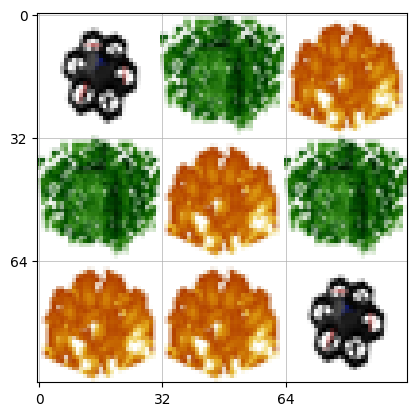

In [ ]:
env = ForestFireEnv()
env.render()

Advantage actor_critic

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.actor = nn.Linear(128, num_outputs)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        policy = torch.softmax(self.actor(x), dim=1)
        value = self.critic(x)
        return policy, value



In [ ]:
def update_agent(agent, optimizer, states, actions, rewards, not_done_flags, gamma=0.99):
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.long)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    not_done_flags = torch.tensor(not_done_flags, dtype=torch.float32)

    _, value = agent(states)
    policy, next_value = agent(states)
    action_dist = Categorical(policy)
    log_prob = action_dist.log_prob(actions).unsqueeze(1)

    delta = rewards + gamma * not_done_flags * next_value - value
    actor_loss = -log_prob * delta.detach()
    critic_loss = delta ** 2

    loss = actor_loss + 0.5 * critic_loss

    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()


In [ ]:
def train_marl_a2c(env, num_agents=2, num_episodes=1500, lr=0.01, gamma=0.99):
    num_inputs = env.observation_space.shape[0] * env.observation_space.shape[1]
    num_outputs = env.action_space.nvec[0]  # Assuming equal action spaces for all agents

    agents = [ActorCritic(num_inputs, num_outputs) for _ in range(num_agents)]
    optimizers = [optim.Adam(agent.parameters(), lr=lr) for agent in agents]

    episode_rewards = []

    for episode in range(num_episodes):
        states = env.reset().reshape(-1)
        states = np.repeat(states[np.newaxis, :], num_agents, axis=0)  # Duplicate state for each agent
        done = False
        total_rewards = np.zeros(num_agents)

        while not done:
            actions = []

            for agent, state in zip(agents, states):
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                policy, _ = agent(state)
                action_dist = Categorical(policy)
                action = action_dist.sample().item()
                actions.append(action)

            next_states, rewards, done, _ = env.step(actions)
            next_states = next_states.reshape(-1)
            next_states = np.repeat(next_states[np.newaxis, :], num_agents, axis=0)  # Duplicate next state for each agent

            for i, (agent, optimizer, state, action, reward, next_state, done_flag) in enumerate(
                    zip(agents, optimizers, states, actions, rewards, next_states, [done])):
                update_agent(agent, optimizer, [state], [action], [reward], [1 - done_flag], gamma)

            states = next_states
            total_rewards += rewards

        episode_rewards.append(total_rewards.mean())
        print(f'Episode {episode + 1}: {total_rewards}')

    # Plot the results
    plt.plot(range(1, num_episodes + 1), episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('MARL A2C')
    plt.show()

    return agents


Episode 1: [1. 1.]
Episode 2: [-20.  -8.]
Episode 3: [ 5. -7.]
Episode 4: [-4.  8.]
Episode 5: [-5.  7.]
Episode 6: [ -8. -20.]
Episode 7: [8. 8.]
Episode 8: [-35. -23.]
Episode 9: [-30. -18.]
Episode 10: [7. 7.]
Episode 11: [-94. -88.]
Episode 12: [-23. -35.]
Episode 13: [-33. -33.]
Episode 14: [-12. -24.]
Episode 15: [-31. -31.]
Episode 16: [ 6. -6.]
Episode 17: [-26. -26.]
Episode 18: [-12.   0.]
Episode 19: [-5.  7.]
Episode 20: [-6. -6.]
Episode 21: [6. 6.]
Episode 22: [-4. -4.]
Episode 23: [-9. -9.]
Episode 24: [-37. -25.]
Episode 25: [-22. -10.]
Episode 26: [-3.  9.]
Episode 27: [-29. -17.]
Episode 28: [-48. -36.]
Episode 29: [-68. -56.]
Episode 30: [-10.   2.]
Episode 31: [-23. -11.]
Episode 32: [-10.   2.]
Episode 33: [-11.   1.]
Episode 34: [-33. -21.]
Episode 35: [-6.  6.]
Episode 36: [-41. -29.]
Episode 37: [-5.  7.]
Episode 38: [-19.  -7.]
Episode 39: [-3.  9.]
Episode 40: [-46. -34.]
Episode 41: [-7.  5.]
Episode 42: [-19.  -7.]
Episode 43: [-4.  8.]
Episode 44: [-76. -64

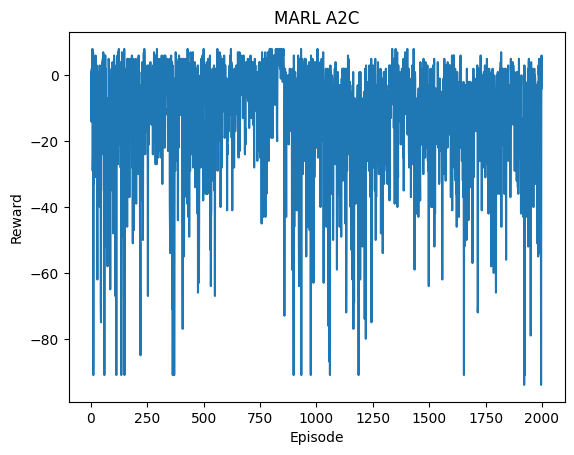

In [ ]:
if __name__ == '__main__':
    env = ForestFireEnv(grid_size=3, max_steps=100)
    trained_agents = train_marl_a2c(env, num_agents=2, num_episodes=2000, lr=0.001)


# Hide and Seek Env 

In [ ]:
 !pip install gymnasium matplotlib numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached gymnasium-0.28.1-py3-none-any.whl (925 kB)


In [ ]:
import gym
import numpy as np
from PIL import Image
from gym import spaces
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class HideAndSeek(gym.Env):

    def __init__(self, grid_size=3, max_steps=100):
        super(HideAndSeek, self).__init__()
        ghost_image = Image.open("ghost.png")
        agent_image = Image.open("pacman.png")

        # Scale the images to fit the cell size
        cell_size = 32  # Define the size of each cell
        self.ghost_image = ghost_image.resize((cell_size, cell_size))
        self.agent_image = agent_image.resize((cell_size, cell_size))
        self.cell_size = 32

        self.grid_size = grid_size
        self.max_steps = max_steps
        self.current_step = 0
        self.action_space = spaces.MultiDiscrete([4, 4])  # Two agents, each can move in 4 directions: up, down, left, right
        self.observation_space = spaces.Box(low=0, high=2, shape=(grid_size, grid_size), dtype=np.uint8)

        self.reset()

    def reset(self):
        self.current_step = 0
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        self.agent_positions = [(0, 0), (self.grid_size - 1, self.grid_size - 1)]
        self.visited_cells = set(self.agent_positions)
        self.grid[self.agent_positions[0]] = 2
        self.grid[self.agent_positions[1]] = 3
        x1,y1=self.agent_positions[0]
        x2,y2=self.agent_positions[1]
        self.prev_dist=np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        # self.prev_dist=abs(x1 - x2) + abs(y1 - y2)

       
        return self.grid

    def step(self, action):
        self.current_step += 1
        rewards = [-1] * len(self.agent_positions)
        # rewards = [-1,+1]
        for i, act in enumerate(action):
            x, y = self.agent_positions[i]
            if act == 0:    # Move up
                x = max(x - 1, 0)
            elif act == 1:  # Move down
                x = min(x + 1, self.grid_size - 1)
            elif act == 2:  # Move left
                y = max(y - 1, 0)
            elif act == 3:  # Move right
                y = min(y + 1, self.grid_size - 1)
            
            self.grid[self.agent_positions[i]] = 0
            self.agent_positions[i] = (x, y)
            self.visited_cells.add((x, y))
            
        x1,y1=self.agent_positions[0]
        x2,y2=self.agent_positions[1]
        dist=np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        # dist=abs(x1 - x2) + abs(y1 - y2)

        done =self.current_step >= self.max_steps  # Episode is done when max_steps reached

        if x1==x2 and y1==y2: #Hider was caught
            rewards[0] =10  # Reward for Seeker
            rewards[1] = 1  # Reward for Hider
            done=True
        else:
          if  dist>self.prev_dist:
              rewards[1] =1  # Reward for Hider
          else:
              rewards[0] = 1  # Reward for Seeker
        self.prev_dist=dist

        self.grid[self.agent_positions[0]] = 2
        self.grid[self.agent_positions[1]] = 3

        info = {
            'agent_positions': self.agent_positions,
            'visited_cells': self.visited_cells,
            'current_step': self.current_step
        }

        return self.grid, rewards, done, info

    def render(self, mode='human'):
        if mode == 'rgb_array':
            return self._get_rgb_array()
        else:
            self._show_plot()

    def _get_rgb_array(self):
        # Create a canvas for the images
        canvas = Image.new('RGB', (self.grid_size * self.cell_size, self.grid_size * self.cell_size), (255, 255, 255))

        # Draw the images on the canvas
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                position = (y * self.cell_size, x * self.cell_size)

                if (x, y) == self.agent_positions[1]:
                    canvas.paste(self.ghost_image, position, self.ghost_image if self.ghost_image.mode == 'RGBA' else None)
                if (x, y) == self.agent_positions[0]:
                    canvas.paste(self.agent_image, position, self.agent_image if self.agent_image.mode == 'RGBA' else None)

        return np.array(canvas)

    def _show_plot(self):
        plt.clf()  # Clear the previous plot

        # Display the canvas using matplotlib
        plt.imshow(self._get_rgb_array())
        plt.xticks(range(0, self.grid_size * self.cell_size, self.cell_size))
        plt.yticks(range(0, self.grid_size * self.cell_size, self.cell_size))
        plt.grid(True, linestyle='-', linewidth=0.5)

        plt.draw()
        plt.pause(0.5)
        plt.show(block=False)



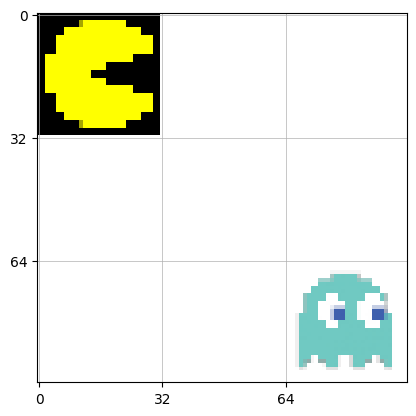

In [ ]:
env = HideAndSeek()
env.render()

DQN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class DQNAgent:
    def __init__(self, state_size, action_size, device, lr=0.001, gamma=0.99, buffer_size=10000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.lr = lr
        self.gamma = gamma
        self.batch_size = batch_size

        self.memory = deque(maxlen=buffer_size)
        self.model = self._build_model().to(device)
        self.target_model = self._build_model().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.update_target_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            return self.model(state).argmax().item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float32, device=self.device)

        current_q_values = self.model(states).gather(1, actions)
        next_q_values = self.target_model(next_states).max(1)[0].detach()
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(current_q_values, target_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


def train_dqn(agents, env, episodes=1000, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, update_frequency=100, early_stopping_patience=50, reward_threshold=15):
    state_size = env.observation_space.shape[0] * env.observation_space.shape[1]
    action_size = env.action_space.nvec[0]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    rewards_history = []
    best_average_reward = float('-inf')
    no_improvement_count = 0

    epsilon = epsilon_start

    for episode in range(episodes):
        state = env.reset().flatten()
        done = False
        total_rewards = [0, 0]

        while not done:
            actions = [agent.choose_action(state, epsilon) for agent in agents]
            next_state, rewards, done, _ = env.step(actions)
            next_state = next_state.flatten()

            for i, agent in enumerate(agents):
                agent.remember(state, actions[i], rewards[i], next_state, done)

            state = next_state
            total_rewards = [total_rewards[i] + rewards[i] for i in range(len(rewards))]

            for agent in agents:
                agent.train()

        if episode % update_frequency == 0:
            for agent in agents:
                agent.update_target_model()

        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        rewards_history.append(total_rewards)

        print(f"Episode {episode + 1}/{episodes} - Agent 1 Reward: {total_rewards[0]}, Agent 2 Reward: {total_rewards[1]}, Epsilon: {epsilon}")

        # Early stopping
        # if episode >= early_stopping_patience:
        #     recent_average_reward = np.mean([r[0] + r[1] for r in rewards_history[-early_stopping_patience:]])
        #     if recent_average_reward > best_average_reward:
        #         best_average_reward = recent_average_reward
        #         no_improvement_count = 0
        #     else:
        #         no_improvement_count += 1

        #     if recent_average_reward >= reward_threshold or no_improvement_count >= early_stopping_patience:
        #         print(f"Early stopping after {episode + 1} episodes")
        #         break

    return rewards_history



# Train the DQN agents
agents = [DQNAgent(state_size=16, action_size=4, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")) for _ in range(2)]
env = HideAndSeek(grid_size=4)
rewards_history = train_dqn(agents, env)



Episode 1/1000 - Agent 1 Reward: 22, Agent 2 Reward: -11, Epsilon: 0.995
Episode 2/1000 - Agent 1 Reward: 14, Agent 2 Reward: -3, Epsilon: 0.990025
Episode 3/1000 - Agent 1 Reward: 13, Agent 2 Reward: -2, Epsilon: 0.985074875
Episode 4/1000 - Agent 1 Reward: 31, Agent 2 Reward: -20, Epsilon: 0.9801495006250001
Episode 5/1000 - Agent 1 Reward: 17, Agent 2 Reward: -6, Epsilon: 0.9752487531218751
Episode 6/1000 - Agent 1 Reward: 22, Agent 2 Reward: -11, Epsilon: 0.9703725093562657
Episode 7/1000 - Agent 1 Reward: 15, Agent 2 Reward: -4, Epsilon: 0.9655206468094844
Episode 8/1000 - Agent 1 Reward: 17, Agent 2 Reward: -6, Epsilon: 0.960693043575437
Episode 9/1000 - Agent 1 Reward: 31, Agent 2 Reward: -20, Epsilon: 0.9558895783575597
Episode 10/1000 - Agent 1 Reward: 26, Agent 2 Reward: -15, Epsilon: 0.9511101304657719
Episode 11/1000 - Agent 1 Reward: 22, Agent 2 Reward: -11, Epsilon: 0.946354579813443
Episode 12/1000 - Agent 1 Reward: 31, Agent 2 Reward: -20, Epsilon: 0.9416228069143757
Ep

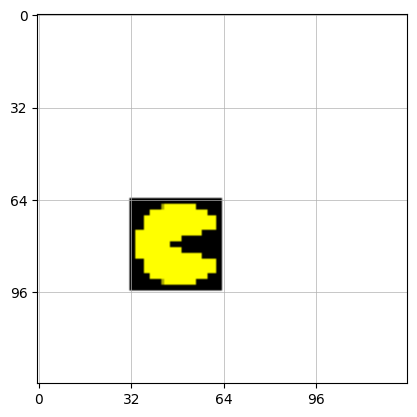

In [ ]:
env.render()

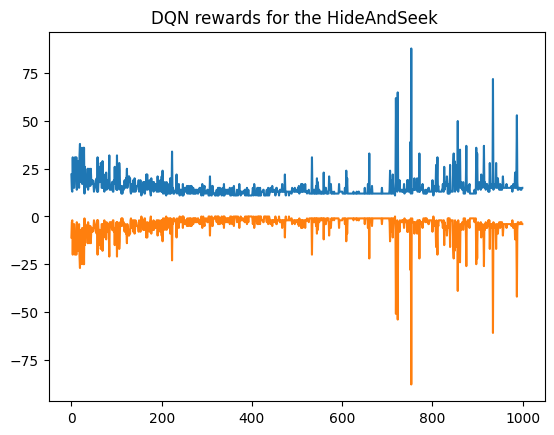

In [ ]:
plt.plot(rewards_history)
plt.title("DQN rewards for the HideAndSeek ")
plt.show() 

Episode 1/10 - Agent 1 Reward: 15, Agent 2 Reward: -4, Steps: 6
Episode 2/10 - Agent 1 Reward: 15, Agent 2 Reward: -4, Steps: 6
Episode 3/10 - Agent 1 Reward: 15, Agent 2 Reward: -4, Steps: 6
Episode 4/10 - Agent 1 Reward: 15, Agent 2 Reward: -4, Steps: 6
Episode 5/10 - Agent 1 Reward: 15, Agent 2 Reward: -4, Steps: 6
Episode 6/10 - Agent 1 Reward: 15, Agent 2 Reward: -4, Steps: 6
Episode 7/10 - Agent 1 Reward: 15, Agent 2 Reward: -4, Steps: 6
Episode 8/10 - Agent 1 Reward: 15, Agent 2 Reward: -4, Steps: 6
Episode 9/10 - Agent 1 Reward: 15, Agent 2 Reward: -4, Steps: 6


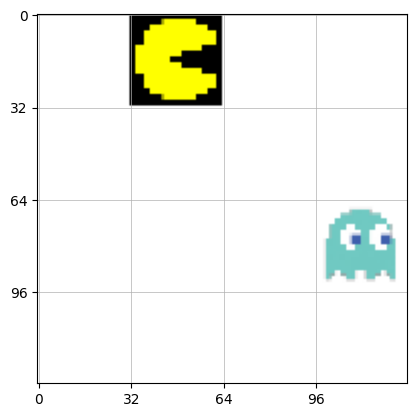

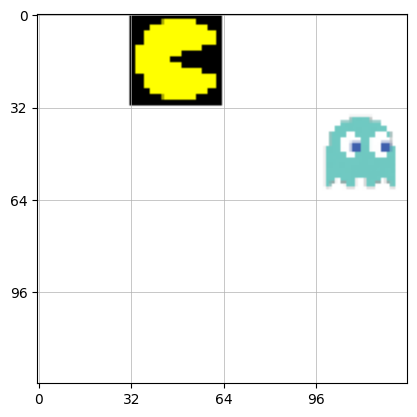

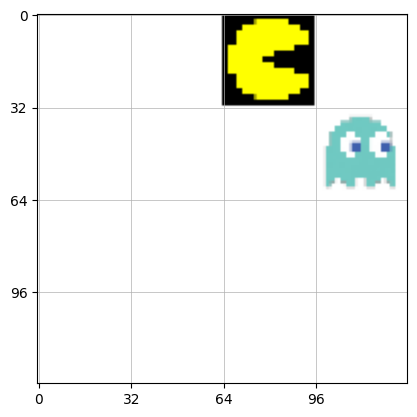

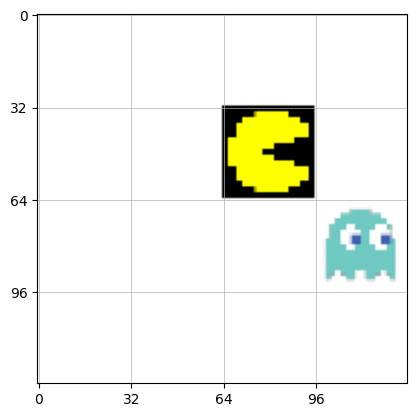

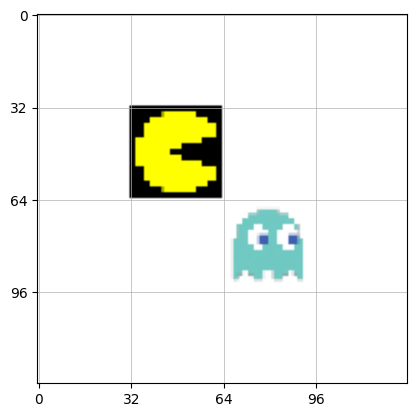

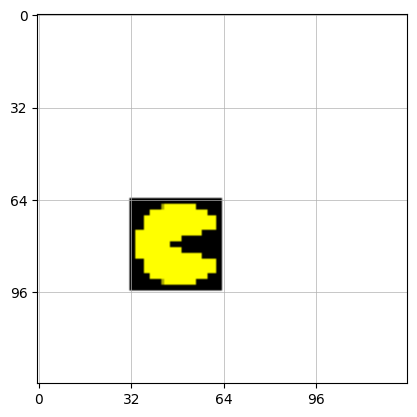

Episode 10/10 - Agent 1 Reward: 15, Agent 2 Reward: -4, Steps: 6


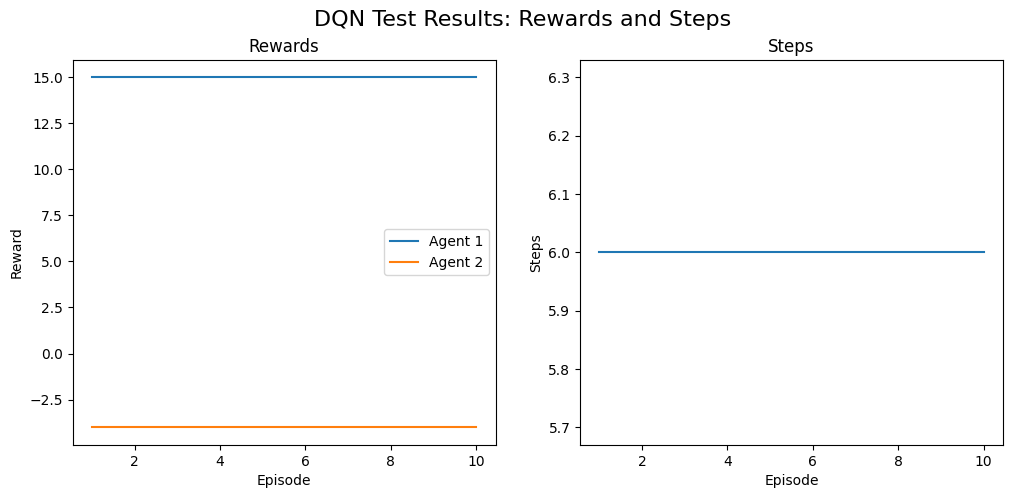

In [ ]:
def test_dqn(agents, env, episodes=10):
    rewards_history = []
    steps_history = []

    for episode in range(episodes):
        state = env.reset().flatten()
        done = False
        total_rewards = [0, 0]
        step_count = 0
        while not done:
            step_count += 1
            
            actions = [agent.choose_action(state, 0) for agent in agents]  # Epsilon is set to 0 for testing (no exploration)
            next_state, rewards, done, _ = env.step(actions)
            next_state = next_state.flatten()
            state = next_state
            total_rewards = [total_rewards[i] + rewards[i] for i in range(len(rewards))]
            if episode==episodes-1:
              env.render()


        print(f"Episode {episode + 1}/{episodes} - Agent 1 Reward: {total_rewards[0]}, Agent 2 Reward: {total_rewards[1]}, Steps: {step_count}")
        rewards_history.append(total_rewards)
        steps_history.append(step_count)
        
    env.close()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))    
    ax1.plot(range(1, episodes + 1), [r[0] for r in rewards_history], label="Agent 1")
    ax1.plot(range(1, episodes + 1), [r[1] for r in rewards_history], label="Agent 2")
    ax1.set_title("Rewards")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Reward")
    ax1.legend()

    ax2.plot(range(1, episodes + 1), steps_history)
    ax2.set_title("Steps")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Steps")
    fig.suptitle("DQN Test Results: Rewards and Steps", fontsize=16)
    plt.show()

test_dqn(agents, env)


Reference:

    1.Class Notes and Links provided in reference documents
    2.openai gym documentation
    3.PIL documentation